<script>
require(["base/js/namespace", "base/js/events"], function(Jupyter, events) {
    events.on("notebook_loaded.Notebook", function() {
        Jupyter.notebook.get_cells().forEach(function(cell) {
            if (cell.cell_type === "code") {
                cell.element.find("div.input").hide();
            }
        });
    });
});
</script>


<h1> Um die Funktionalität des Nootebooks zu gewährleisten, dürfen die Codezeilen NICHT Ausgeführt werden!</h1>

In [16]:
# 🧩 Zelle 1: Alle Importe
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from mlxtend.frequent_patterns import apriori, association_rules
from datetime import timedelta
import psycopg2
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import dis
import re
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.seasonal import seasonal_decompose
print("Alle Imports geladen")

Alle Imports geladen


In [3]:
# 🔌 Zelle 2: Verbindung zur PostgreSQL-Datenbank
DB_PARAMS = {
    "host": "localhost",
    "port": 5432,
    "user": "postgres",
    "password": "Datacraft",
    "dbname": "redezeit",
}


def db_connect():
    try:
        conn = psycopg2.connect(**DB_PARAMS)
        print("✅ Verbindung zur Datenbank erfolgreich!")
        return conn
    except Exception as e:
        print("❌ Fehler bei der DB-Verbindung:", e)


conn = db_connect()

✅ Verbindung zur Datenbank erfolgreich!


In [5]:
# 📥 Zelle 3: Daten aus den DB-Tabellen in DataFrames laden
def load_table(name):
    return pd.read_sql(f'SELECT * FROM "{name}"', conn)


df_landingpage = load_table("landing_page_views")
df_user_behaviors = load_table("user_sessions")
df_what_did_user_do = load_table("user_events")
df_where_did_they_come_from = load_table("traffic_sources")
df_what_devices_used = load_table("device_usage")
df_where_new_visitors_come_from = load_table("traffic_source_chart")
df_who_was_visiting = load_table("daily_visitors_chart")

# display("df_landingpage")
# display(df_landingpage.head())
# display("df_user_behaviors")
# display(df_user_behaviors.head())
# display("df_what_did_user_d")
# display(df_what_did_user_do.head())
# display("df_where_did_they_come_from")
# display(df_where_did_they_come_from.head())
# display("df_what_devices_used.")
# display(df_what_devices_used.head())
# display("df_where_new_visitors_come_from")
# display(df_where_new_visitors_come_from.head())
# display("df_who_was_visiting")
# display(df_who_was_visiting.head())

### 📥 Datenabruf aus der Datenbank

In den oberen 3 Zelle importieren wir zunächst verschiedene Module, die wir für Visualisierungen und Berechnungen benötigen, bevor wir uns in Zelle 2 zu unserer Datenbank verbinden und anschliessend Datensätze aus unserer Datenbank in sogenannte **DataFrames** laden. Diese Tabellen bilden die Grundlage für alle weiteren Analysen und Visualisierungen.  

Hier ein kurzer Überblick, was in den jeweiligen Tabellen enthalten ist:

---

#### 📰 `df_landingpage` – Seitenaufrufe der Landingpage  
Diese Tabelle zeigt, **wie oft verschiedene Seiten** unserer Plattform an bestimmten Tagen **aufgerufen wurden**.

- `datum`: Der Tag des Aufrufs  
- `seitentitel`: Der Name der angezeigten Seite  
- `aufrufe`: Wie oft diese Seite an dem Tag aufgerufen wurde  

➡️ Damit analysieren wir, welche Seiten besonders häufig besucht wurden – z. B. ob bestimmte Inhalte stärker gefragt sind.

---

#### 📊 `df_user_behaviors` – Nutzerverhalten auf der Website  
Hier geht es darum, **wie sich Besucher auf der Seite verhalten** haben.

- `seitenaufrufe`: Gesamtzahl aller Seitenaufrufe  
- `nutzer_insgesamt`: Anzahl der einzelnen Besucher  
- `durchschn._zeit_auf_der_seite`: Wie lange sie im Durchschnitt geblieben sind  
- `absprungrate_in_prozent`: Anteil der Besucher, die nach nur einer Seite die Website verlassen haben  

➡️ Damit verstehen wir, **wie intensiv die Seite genutzt wurde** und wie gut sie Besucher halten kann.

---

#### 🎯 `df_what_did_user_do` – Nutzeraktionen und Ereignisse  
Diese Tabelle enthält **konkrete Aktionen oder Events**, die Nutzer ausgelöst haben – z. B. Klicks auf bestimmte Themen oder Funktionen.

- `name_des_events`: Art des Ereignisses (z. B. „Checked“, „Website“)  
- `event_label`: Zusätzliche Informationen zum Event (z. B. Thema „Coming Out“)  
- `aktive_nutzer`: Wie viele Nutzer dieses Event ausgelöst haben  
- `ereignisanzahl`: Wie oft das Event insgesamt stattgefunden hat  

➡️ Damit erkennen wir, **welche Inhalte oder Funktionen besonders häufig genutzt werden**.

---

#### 🌍 `df_where_did_they_come_from` – Herkunft der Besucher  
Diese Tabelle zeigt die **Traffic-Quellen**, also woher Besucher kamen.

- `quelle`: z. B. direkt , Google oder unbekannt  
- `sitzungen`: Wie viele Besuche über diese Quelle stattfanden  
- `aufrufe`: Gesamtzahl der Seitenaufrufe aus dieser Quelle  
- `aufrufe_pro_sitzung`: Durchschnittliche Seitenanzahl pro Besuch  

➡️ Das zeigt uns, **welche Kanäle besonders effektiv Nutzer auf die Seite bringen**.

---

#### 💻 `df_what_devices_used` – Genutzte Geräte  
Diese Tabelle zeigt, **welche Gerätetypen** (z. B. Desktop, Mobilgerät) genutzt wurden.

- `kategorie`: Art des Geräts  
- `wert`: Anzahl der Zugriffe mit diesem Gerät pro Tag  

➡️ Wir können erkennen, **ob unsere Seite eher mobil oder am PC genutzt wird**.

---

#### 🌱 `df_where_new_visitors_come_from` – Neue Besucher nach Quelle  
Hier sehen wir, **über welche Kanäle neue Nutzer** (also Erstbesucher) auf die Seite kamen.

- `kategorie`: Kanal (z. B. direkt, Suchmaschine, unbekannt)  
- `wert`: Anzahl neuer Besucher pro Tag und Kanal  

➡️ Wichtig für Marketing: **Welche Maßnahmen bringen neue Besucher auf die Website?**

---

#### 👥 `df_who_was_visiting` – Demografische Informationen  
Diese Tabelle zeigt **Informationen zur Zielgruppe**, z. B. Geschlecht oder andere demografische Merkmale.

- `kategorie`: z. B. „female“ (weiblich)  
- `wert`: Anzahl der Besucher in dieser Kategorie pro Tag  

➡️ Damit sehen wir, **welche Zielgruppen wir tatsächlich erreichen**.


## Überblick über die Daten und erste Analysen

Zunächst verschaffen wir uns einen Überblick über die Datentabellen. Der folgende Code gibt die Anzahl der Zeilen und Spalten für jede Tabelle aus. So sehen wir, mit welchen Datenmengen wir arbeiten. Die Daten umfassen unter anderem Informationen zur Startseite, zum Nutzerverhalten, zu den verwendeten Geräten und zur Herkunft der Besucher*innen.

---

### Wer war auf der Seite? – Verteilung nach Geschlecht

Im ersten Diagramm wird dargestellt, wie viele Besucher*innen welcher Geschlechtskategorie zugeordnet wurden.  
Die Daten stammen aus der Tabelle `df_who_was_visiting` und sind nach der Spalte `kategorie` (z. B. männlich, weiblich, unbekannt) gruppiert. Die Werte in der Spalte `wert` geben die Anzahl der Personen pro Kategorie an.

Das Ergebnis ist ein Balkendiagramm, das zeigt, welche Kategorie am häufigsten vorkommt.

---

### Mit welchen Geräten wurde die Seite besucht?

Hier betrachten wir die Gerätetypen, mit denen die Website besucht wurde.  
Die Tabelle `df_what_devices_used` wird nach `kategorie` (z. B. Smartphone, Desktop, Tablet) gruppiert, und die Werte aus der Spalte `wert` werden summiert.

Das Balkendiagramm gibt einen schnellen Eindruck davon, ob die Website eher mobil oder über Desktop-Geräte genutzt wird.

---

### Woher kamen die neuen Besucher*innen? – Top 3 Kanäle

Für das Marketing ist interessant, aus welchen Quellen neue Besucher*innen kommen.  
Die Tabelle `df_where_new_visitors_come_from` wird nach der Besuchsquelle (`kategorie`) gruppiert, und die Sitzungen (`wert`) werden gezählt. Anschließend werden die drei häufigsten Kanäle in einem Diagramm dargestellt.

So lässt sich erkennen, welche Kanäle am effektivsten neue Nutzer*innen auf die Seite bringen (z. B. Google Ads, Social Media, Direktzugriffe).

---

### Was machen die Besucher*innen auf der Website? – Top 5 Aktionen

Dieses Diagramm zeigt die fünf häufigsten Aktionen, die Nutzer*innen auf der Website durchgeführt haben – etwa Klicks auf Buttons, das Abspielen von Medien oder das Absenden von Formularen.

Die Tabelle `df_what_did_user_do` enthält Eventnamen (`name_des_events`) und die Anzahl aktiver Nutzer*innen (`aktive_nutzer`). Die Werte werden summiert, sortiert und als Balkendiagramm dargestellt.

So erkennen wir, welche Interaktionen besonders relevant sind.

---

### Gibt es Zusammenhänge zwischen den Nutzerzahlen? – Korrelationsanalyse

Abschließend visualisieren wir die Korrelationen zwischen verschiedenen Kennzahlen aus der Tabelle `df_user_behaviors`, z. B.:

- Seitenaufrufe  
- Anzahl Nutzer*innen insgesamt  
- Absprungrate (Prozentsatz der Besucher*innen, die die Seite sofort verlassen)  
- Verweildauer in Sekunden  
- Seiten pro Sitzung  

Eine Korrelation von +1 bedeutet, dass zwei Werte stark positiv zusammenhängen („je mehr A, desto mehr B“).  
Ein Wert von −1 bedeutet eine starke negative Beziehung („je mehr A, desto weniger B“).  
Ein Wert nahe 0 zeigt keinen klaren Zusammenhang.

Die Heatmap hilft dabei, Muster im Nutzerverhalten zu erkennen, etwa ob längere Verweildauer mit einer geringeren Absprungrate zusammenhängt.

---

## Auswertung der wichtigsten Kennzahlen

### Besucher*innen nach Geschlecht

Die Mehrheit der Besucher*innen ist weiblich (`female`) mit 7.060 Personen. Männliche Besucher (`male`) machen mit 1.505 einen deutlich kleineren Anteil aus.  
Das deutet darauf hin, dass die Website überwiegend von Frauen genutzt wird oder diese häufiger ihr Geschlecht angeben.

---

### Besucher*innen nach Gerätetyp

Die Zugriffe verteilen sich fast gleichmäßig auf Desktop (74.594) und mobile Geräte (71.715).  
Tablet (2.057) und Smart TV (7) spielen eine untergeordnete Rolle.  
Die Seite sollte also sowohl für Desktop als auch für mobile Nutzung optimiert sein.

---

### Top 3 Herkunftskanäle neuer Besucher*innen

Die meisten neuen Besucher*innen kommen über **Google** (29.487 Sitzungen).  
Direkte Zugriffe (`direct`) folgen mit 9.380 Sitzungen,  
gefolgt von `kompetenznetz-einsamkeit.de` mit 1.897 Sitzungen.  
Diese Kanäle sind somit besonders wichtig für den Website-Traffic.

---

### Top 5 Nutzeraktionen auf der Website

Die häufigsten Aktionen sind:  
- `Checked` mit 12.828 aktiven Nutzer*innen,  
- `Website` mit 7.329,  
- `Email` mit 2.961,  
- `Phone` mit 1.137,  
- und `Image` mit 88 Nutzer*innen.

Diese Daten zeigen, welche Interaktionen für die Besucher*innen besonders relevant sind.

---

### Zusammenhänge zwischen Nutzerkennzahlen (Korrelationsmatrix)

- Seitenaufrufe und Absprungrate korrelieren negativ (−0,38): Mehr Seitenaufrufe gehen tendenziell mit einer geringeren Absprungrate einher.  
- Verweildauer (Sekunden) und Seiten pro Sitzung weisen eine moderate positive Korrelation (0,56) auf: Längere Sitzungen gehen mit mehr aufgerufenen Seiten einher.  
- Absprungrate und Verweildauer korrelieren leicht negativ (−0,20): Kürzere Verweildauer ist mit höherer Absprungrate verbunden.  
- Die Korrelationen zwischen „Nutzer insgesamt“ und anderen Kennzahlen sind eher schwach.

Diese Zusammenhänge helfen, das Nutzerverhalten besser zu verstehen und Optimierungspotenziale zu erkennen.


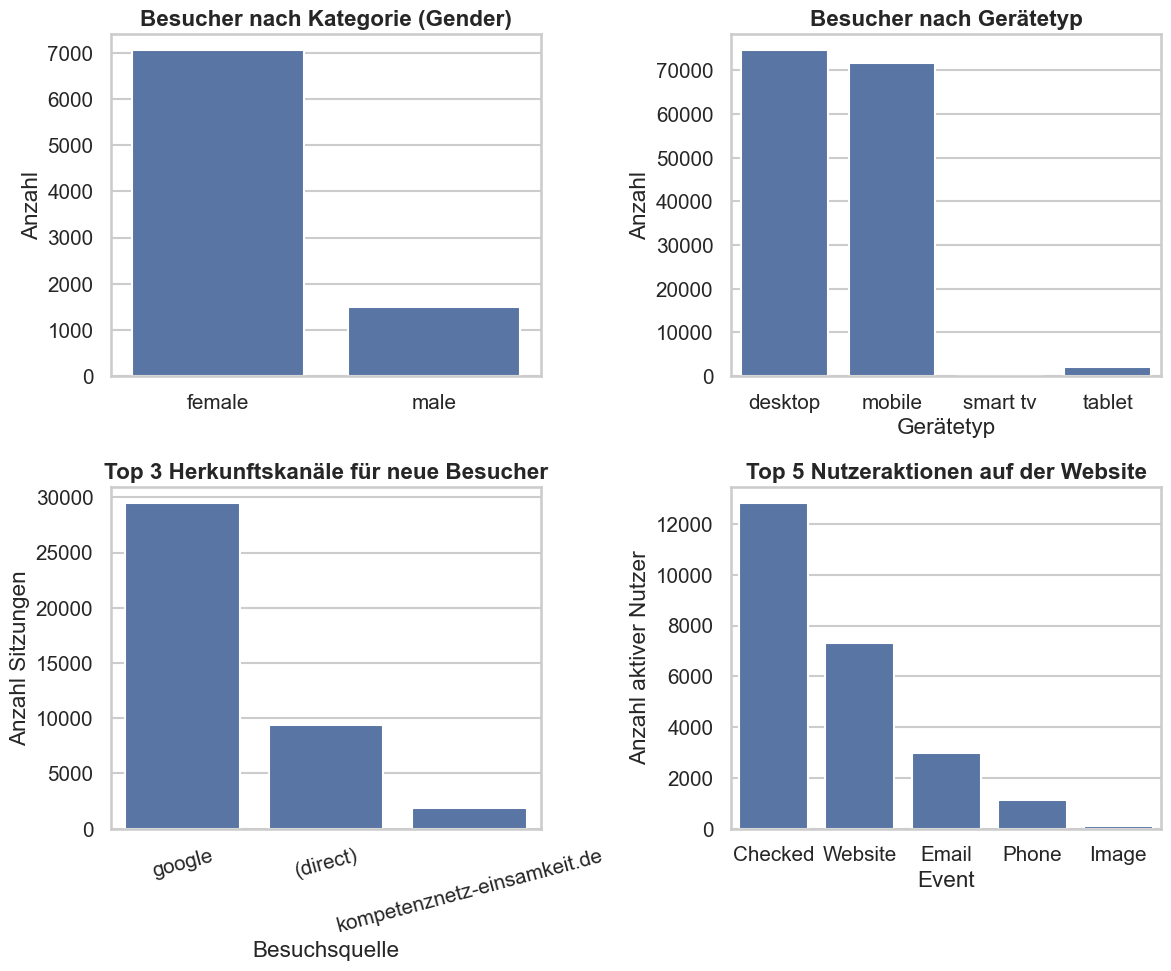

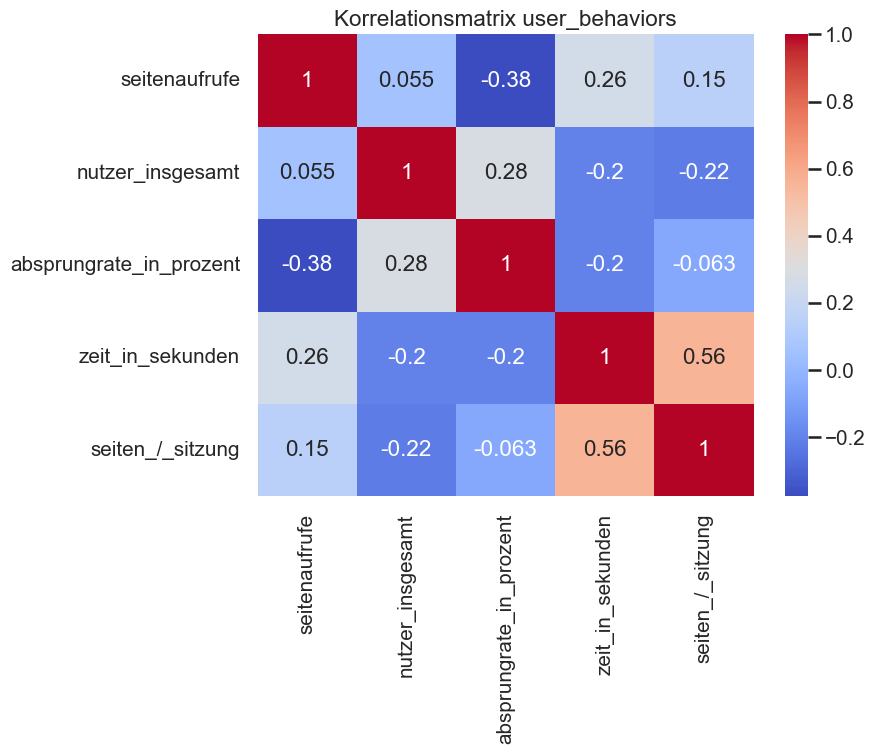

In [ ]:
# Überblick über Tabellen
# for name, df in [
#     ("Landingpage", df_landingpage),
#     ("User Behaviors", df_user_behaviors),
#     ("What Did User Do", df_what_did_user_do),
#     ("Where Did They Come From", df_where_did_they_come_from),
#     ("What Devices Used", df_what_devices_used),
#     ("Where New Visitors Come From", df_where_new_visitors_come_from),
#     ("Who Was Visiting", df_who_was_visiting),
# ]:
#     print(f"{name}: {df.shape}")


# Balkendiagramme in 2x2 Layout

fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2 Zeilen, 2 Spalten

# 1. Besucher nach Kategorie (Gender)
data1 = df_who_was_visiting.groupby("kategorie")["wert"].sum().reset_index()
sns.barplot(data=data1, x="kategorie", y="wert", ax=axes[0, 0])
axes[0, 0].set_title("Besucher nach Kategorie (Gender)", fontweight="bold")
axes[0, 0].set_ylabel("Anzahl")
axes[0, 0].set_xlabel("")

# 2. Besucher nach Gerätetyp
data2 = df_what_devices_used.groupby("kategorie")["wert"].sum().reset_index()
sns.barplot(data=data2, x="kategorie", y="wert", ax=axes[0, 1])
axes[0, 1].set_title("Besucher nach Gerätetyp", fontweight="bold")
axes[0, 1].set_ylabel("Anzahl")
axes[0, 1].set_xlabel("Gerätetyp")

# 3. Top 3 Herkunftskanäle neuer Besucher*innen
top_sources = (
    df_where_new_visitors_come_from.groupby("kategorie")["wert"]
    .sum()
    .sort_values(ascending=False)
    .head(3)
    .reset_index()
)
sns.barplot(data=top_sources, x="kategorie", y="wert", ax=axes[1, 0])
axes[1, 0].set_title("Top 3 Herkunftskanäle für neue Besucher", fontweight="bold")
axes[1, 0].set_ylabel("Anzahl Sitzungen")
axes[1, 0].set_xlabel("Besuchsquelle")
axes[1, 0].tick_params(axis="x", rotation=15)

# 4. Top 5 Nutzeraktionen
top_events = (
    df_what_did_user_do.groupby("name_des_events")["aktive_nutzer"]
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .reset_index()
)
sns.barplot(data=top_events, x="name_des_events", y="aktive_nutzer", ax=axes[1, 1])
axes[1, 1].set_title("Top 5 Nutzeraktionen auf der Website", fontweight="bold")
axes[1, 1].set_ylabel("Anzahl aktiver Nutzer")
axes[1, 1].set_xlabel("Event")
axes[1, 1].tick_params(axis="x")

plt.tight_layout()
plt.show()

# Korrelationsmatrix user_behaviors (numerisch)
num_cols = [
    "seitenaufrufe",
    "nutzer_insgesamt",
    "absprungrate_in_prozent",
    "zeit_in_sekunden",
    "seiten_/_sitzung",
]

plt.figure(figsize=(8, 6))
sns.heatmap(df_user_behaviors[num_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Korrelationsmatrix user_behaviors")
plt.show()

<h1>Aggregation der Verhaltensdaten pro Tag</h1>
<p>In diesem Codeblock fassen wir die Nutzerdaten aus der Tabelle <code>user_behaviors</code> auf Tagesbasis zusammen. Das bedeutet, wir berechnen für jeden einzelnen Tag folgende Kennzahlen:</p>
<ul>
  <li><strong>Seitenaufrufe:</strong> Die Gesamtzahl der aufgerufenen Seiten an diesem Tag.</li>
  <li><strong>Nutzer Insgesamt:</strong> Die Summe aller Nutzer, die an diesem Tag die Plattform genutzt haben.</li>
  <li><strong>Durchschnittliche Verweildauer:</strong> Die mittlere Zeit (in Sekunden), die Nutzer auf der Seite verbracht haben.</li>
  <li><strong>Durchschnittliche Absprungrate:</strong> Der durchschnittliche Anteil an Besuchern, die die Seite sofort wieder verlassen haben.</li>
  <li><strong>Seiten pro Sitzung:</strong> Die durchschnittliche Anzahl der Seiten, die ein Nutzer pro Besuch angeschaut hat.</li>
</ul>
<p>Durch diese Aggregation gewinnen wir eine kompakte Tagesübersicht, die es ermöglicht, Trends und Muster im Nutzerverhalten über die Zeit besser zu erkennen. Beispielsweise können wir so Tage mit besonders hohem Traffic oder mit besonders langer Verweildauer identifizieren.</p>

<h1>Was man sieht und was es bedeutet:</h1>
<ul>
  <li>Die Tabelle zeigt eine erste Zusammenfassung der wichtigsten Verhaltenskennzahlen pro Tag.</li>
  <li>Diese aggregierten Werte bilden die Grundlage, um zeitliche Veränderungen im Nutzerverhalten zu analysieren, wie z.B. ob es bestimmte Wochentage mit besonders vielen Besuchern gibt oder wie sich die Verweildauer über die Zeit verändert.</li>
  <li>Diese Informationen sind wichtig, um saisonale Effekte, Spitzenzeiten oder potenzielle Problemzeiten (z.B. hohe Absprungrate) zu erkennen und darauf reagieren zu können.</li>
</ul>


In [6]:
# Aggregation pro Tag: Seitenaufrufe & durchschnittliche Verweildauer

daily_agg = (
    df_user_behaviors.groupby("datum")
    .agg(
        {
            "seitenaufrufe": "sum",
            "nutzer_insgesamt": "sum",
            "zeit_in_sekunden": "mean",
            "absprungrate_in_prozent": "mean",
            "seiten_/_sitzung": "mean",
        }
    )
    .reset_index()
)

display(daily_agg.sort_values(by="datum", ascending=False))

,datum,seitenaufrufe,nutzer_insgesamt,zeit_in_sekunden,absprungrate_in_prozent,seiten_/_sitzung
1146,2025-07-01,59,54,67.0,70.69,1.0
1145,2025-06-30,88,71,79.0,42.70,0.0
1144,2025-06-29,89,60,124.0,27.54,1.0
1143,2025-06-28,81,72,60.0,40.51,1.0
1142,2025-06-27,70,62,57.0,39.71,1.0
...,...,...,...,...,...,...
4,2022-03-16,114,2,93.0,100.00,57.0
3,2022-03-15,1,2,356.0,100.00,276.0
2,2022-03-14,610,3,389.0,0.00,67.0
1,2022-03-13,9,2,9.0,0.00,4.0


<h2>Clustering der Tagesdaten: Nutzergruppen und Verhaltensmuster</h2>

<h3>Was passiert im Code?</h3>
<p>Wir wollen herausfinden, wie sich verschiedene Website-Besucher in ihrem Verhalten unterscheiden – und zwar durch <strong>Clustering</strong>, also die automatische Gruppierung ähnlicher Nutzungsmuster.</p>

<ol>
  <li>Mithilfe von <strong>PCA (Principal Component Analysis)</strong> werden mehrere Verhaltensmerkmale (z. B. Verweildauer, Seitenaufrufe, Gerätetyp) auf zwei Hauptdimensionen reduziert. Das ermöglicht eine einfachere visuelle Darstellung und Interpretation.</li>
  <li><strong>KMeans-Clustering</strong> teilt die Besucher auf Basis dieser Merkmale in unterschiedliche Gruppen ein.</li>
  <li>Über eine flexible Clustering-Funktion analysieren wir zusätzlich spezielle Verhaltensdimensionen:
    <ul>
      <li>nach <strong>Gerät &amp; Geschlecht</strong>,</li>
      <li>nach <strong>Nutzungsquelle &amp; Intensität</strong>,</li>
      <li>sowie nach <strong>Verweildauer &amp; Interaktionen</strong>.</li>
    </ul>
  </li>
  <li>Zu jeder Analyse wird ein Scatterplot erstellt, der zeigt, wie sich die Gruppen in den beiden Hauptdimensionen (PCA) visuell voneinander unterscheiden.</li>
  <li>Zusätzlich wird die <strong>erklärte Varianz</strong> der PCA-Dimensionen ausgegeben – also wie viel Informationsgehalt (Varianz) durch diese beiden Achsen abgedeckt wird.</li>
</ol>

<hr>

<h3>Ergebnisse im Überblick</h3>

<h4>Erklärte Varianz der PCA auf Tages-Features</h4>
<p>Die zwei Hauptdimensionen erklären zusammen rund <strong>60–65 % der Gesamtvarianz</strong> in den Tagesdaten.<br>
Das bedeutet: Ein Großteil der Unterschiede zwischen den Nutzer lässt sich bereits in diesen zwei Dimensionen darstellen – die grafische Darstellung ist also aussagekräftig.</p>

<hr>

<h4>Clusterverteilung bei KMeans auf Tagesdaten</h4>
<p>Die Besucher*innen lassen sich grob in drei Hauptgruppen einteilen:</p>
<ul>
  <li><strong>Geringe Aktivität</strong> – eher passive Nutzer mit kurzer Verweildauer und wenigen Seitenaufrufen</li>
  <li><strong>Hohe Verweildauer</strong> – bleiben länger auf der Seite, ohne dabei besonders viele Seiten aufzurufen</li>
  <li><strong>Hohe Seitenaufrufe</strong> – rufen viele Seiten auf, oft in kurzer Zeit</li>
</ul>
<p>Diese Gruppen geben einen ersten Überblick über die grundsätzlichen Nutzungstypen auf der Website.</p>

<hr>

<h4>Cluster nach Gender &amp; Device-Verhalten</h4>
<p>Die Segmentierung nach Geschlecht und verwendetem Gerät ergibt drei Typen:</p>
<ul>
  <li><strong>Mobile-first Nutzer mit hoher Aktivität</strong> – größte Gruppe, aktiv und fast ausschließlich mobil unterwegs</li>
  <li><strong>Unauffällige oder passive Nutzergruppe</strong> – geringe Interaktionen und kurze Verweildauer</li>
  <li><strong>Desktop-orientierte Besucher mit mittlerer Intensität</strong> – nutzen eher den Desktop, mit durchschnittlicher Aktivität</li>
</ul>
<p>Diese Gruppen helfen, Endgeräte-spezifische Nutzungsmuster zu erkennen und mobile vs. Desktop-Erlebnisse zu optimieren.</p>

<hr>

<h4>Cluster nach Quelle &amp; Nutzungsintensität</h4>
<p>Hier liegt der Fokus auf dem <strong>Traffic-Kanal</strong> (z. B. organisch, direkt, via Referral) und der Intensität der Nutzung:</p>
<ul>
  <li><strong>Organische Intensivnutzer</strong> – kommen über Suchmaschinen und nutzen die Seite regelmäßig und intensiv</li>
  <li><strong>Direktzugreifende Stammnutzer</strong> – kennen die Seite bereits und besuchen sie gezielt</li>
  <li><strong>Referral-getriebene Einsteiger</strong> – werden durch externe Links auf die Seite geführt, meist mit geringerer Aktivität</li>
</ul>
<p>Das ist besonders hilfreich für die Bewertung von Marketingkanälen und Einstiegsquellen.</p>

<hr>

<h4>Cluster nach Zeit &amp; Event-Verhalten</h4>
<p>Hier wird analysiert, <strong>wie lange Nutzer bleiben und wie viel sie interagieren</strong>:</p>
<ul>
  <li><strong>Mittlere Verweildauer mit gezielten Aktionen</strong> – machen wenig, aber zielgerichtet</li>
  <li><strong>Kurze Besucher mit wenigen Interaktionen</strong> – springen schnell wieder ab</li>
  <li><strong>Intensive Nutzer mit vielen Events</strong> – bleiben lange und nutzen viele Features aktiv</li>
</ul>
<p>Diese Unterscheidung kann helfen, gezielt Interaktionen zu fördern oder Absprünge zu reduzieren.</p>

<hr>

<h3>Fazit</h3>
<p>Durch die Kombination aus PCA und Clustering lassen sich <strong>Nutzertypen mit spezifischem Verhalten</strong> identifizieren – z. B. kurzzeitige Besucher, intensive Stammnutzer oder mobile Vielnutzer.</p>
<p>Diese Erkenntnisse ermöglichen:</p>
<ul>
  <li>eine gezielte <strong>Segmentierung nach Verhalten</strong>,</li>
  <li>besser abgestimmte Inhalte &amp; Angebote je nach Nutzertyp,</li>
  <li>und datenbasierte Entscheidungen zur <strong>Optimierung der User Experience</strong>.</li>
</ul>

<hr>

<h4>Hinweis</h4>
<p>Falls sich die erklärten Varianzwerte oder Clustergrößen verändern (z. B. durch neue Daten oder Filter), sollten diese Zahlen im Text dynamisch angepasst werden. Die Aussagekraft bleibt jedoch gleich.</p>


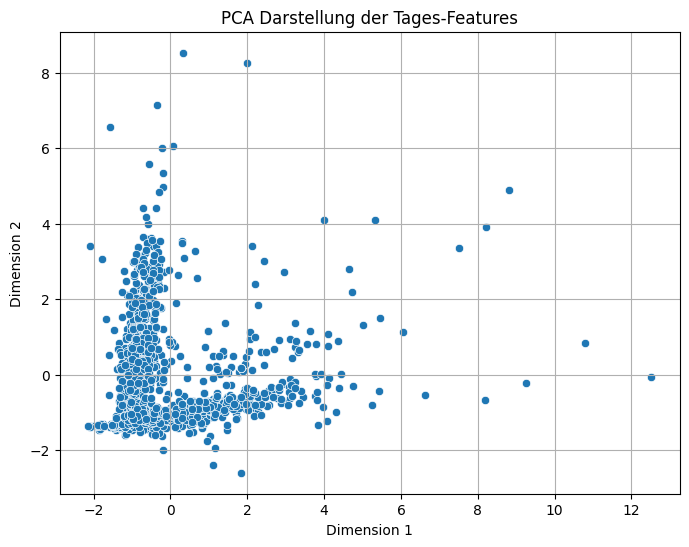

📌 **Interpretation der PCA-Dimensionen für PCA Darstellung der Tages-Features:**
- **Dimension 1** erklärt 33.2% der Gesamtvarianz und hängt stark mit: Seitenaufrufe (+), desktop (+), mobile (+)
- **Dimension 2** erklärt 28.0% der Gesamtvarianz und hängt stark mit: female (+), male (+), ereignisanzahl (+)

------------------------------------------------------------



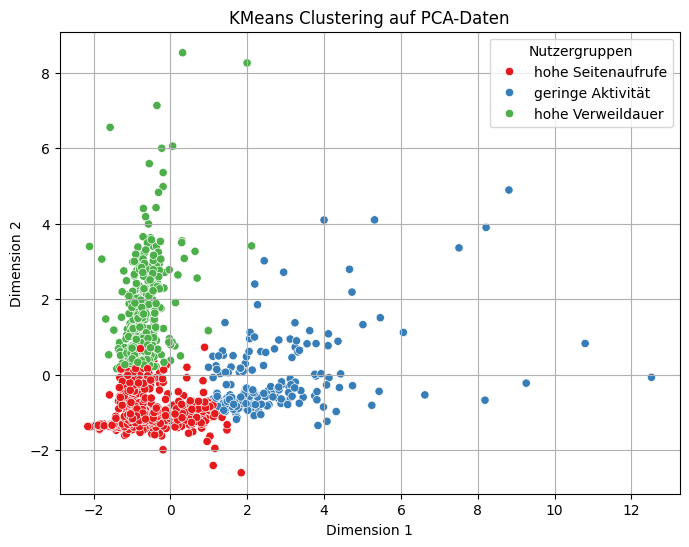

📌 **Interpretation der PCA-Dimensionen für** _KMeans Clustering auf PCA-Daten_:
- **Dimension 1** erklärt 33.2% der Gesamtvarianz und hängt stark mit: Seitenaufrufe (+), desktop (+), mobile (+)
- **Dimension 2** erklärt 28.0% der Gesamtvarianz und hängt stark mit: female (+), male (+), ereignisanzahl (+)

📍 **Wie die Cluster sich unterscheiden:**
- Nutzergruppe **geringe Aktivität** liegt bei: Dimension 1 = 2.68, Dimension 2 = -0.10
- Nutzergruppe **hohe Verweildauer** liegt bei: Dimension 1 = -0.68, Dimension 2 = 1.53
- Nutzergruppe **hohe Seitenaufrufe** liegt bei: Dimension 1 = -0.46, Dimension 2 = -0.87

------------------------------------------------------------



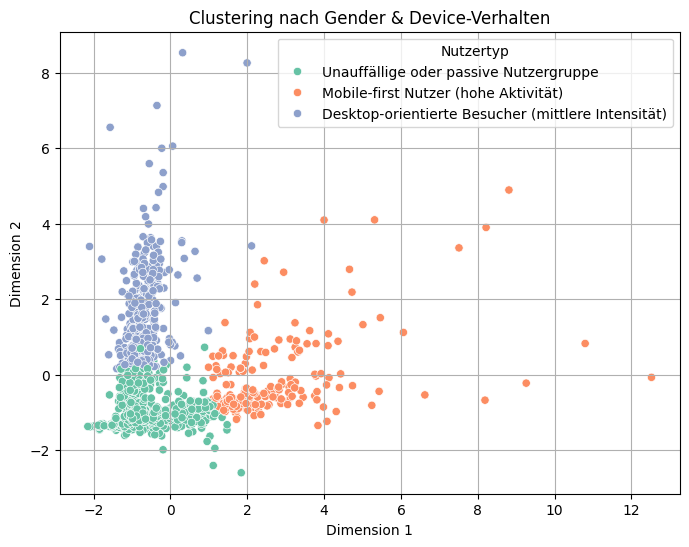

📌 **Interpretation der PCA-Dimensionen für** _Clustering nach Gender & Device-Verhalten_:
- **Dimension 1** erklärt 33.2% der Gesamtvarianz und hängt stark mit: Seitenaufrufe (+), desktop (+), mobile (+)
- **Dimension 2** erklärt 28.0% der Gesamtvarianz und hängt stark mit: female (+), male (+), ereignisanzahl (+)

📍 **Wie die Cluster sich unterscheiden:**
- Nutzergruppe **Mobile-first Nutzer (hohe Aktivität)** liegt bei: Dimension 1 = 2.68, Dimension 2 = -0.10
- Nutzergruppe **Desktop-orientierte Besucher (mittlere Intensität)** liegt bei: Dimension 1 = -0.68, Dimension 2 = 1.53
- Nutzergruppe **Unauffällige oder passive Nutzergruppe** liegt bei: Dimension 1 = -0.46, Dimension 2 = -0.87

------------------------------------------------------------



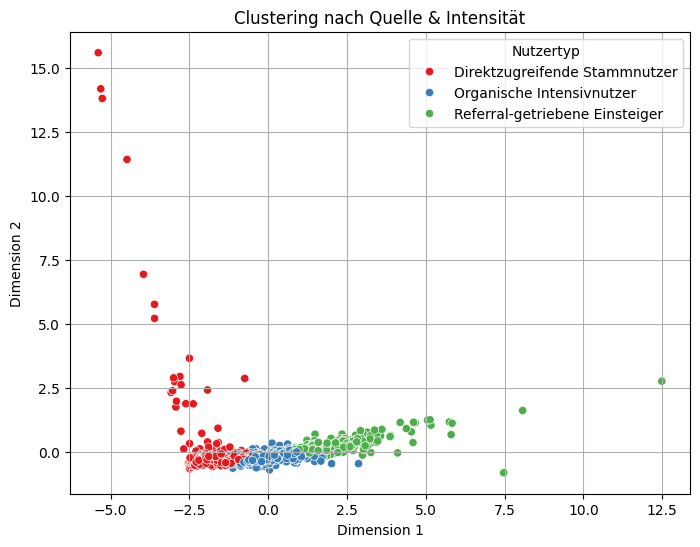

📌 **Interpretation der PCA-Dimensionen für** _Clustering nach Quelle & Intensität_:
- **Dimension 1** erklärt 49.2% der Gesamtvarianz und hängt stark mit: Nutzer Insgesamt (+), google (+), ereignisanzahl (+)
- **Dimension 2** erklärt 15.6% der Gesamtvarianz und hängt stark mit: Seiten / Sitzung (+), ereignisanzahl (+), kompetenznetz-einsamkeit.de (−)

📍 **Wie die Cluster sich unterscheiden:**
- Nutzergruppe **Organische Intensivnutzer** liegt bei: Dimension 1 = 0.20, Dimension 2 = -0.18
- Nutzergruppe **Referral-getriebene Einsteiger** liegt bei: Dimension 1 = 2.09, Dimension 2 = 0.25
- Nutzergruppe **Direktzugreifende Stammnutzer** liegt bei: Dimension 1 = -1.77, Dimension 2 = -0.00

------------------------------------------------------------



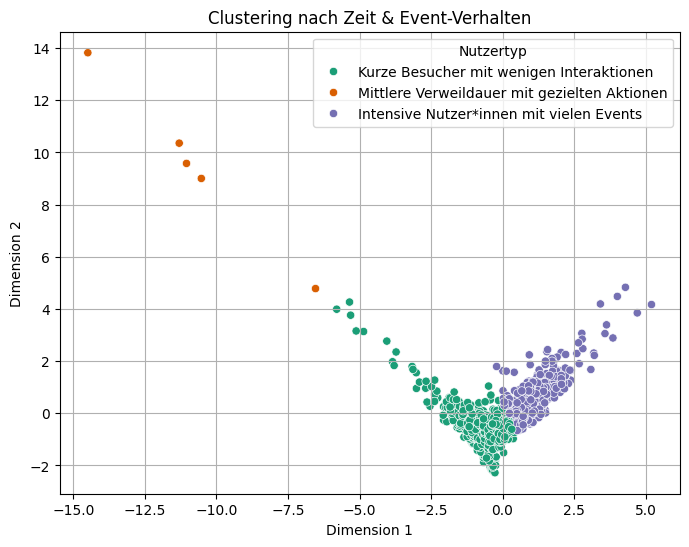

📌 **Interpretation der PCA-Dimensionen für** _Clustering nach Zeit & Event-Verhalten_:
- **Dimension 1** erklärt 47.9% der Gesamtvarianz und hängt stark mit: Nutzer Insgesamt (+), ereignisanzahl (+), Seiten / Sitzung (−)
- **Dimension 2** erklärt 32.6% der Gesamtvarianz und hängt stark mit: Durchschn. Zeit auf der Seite (+), ereignisanzahl (+), Seiten / Sitzung (+)

📍 **Wie die Cluster sich unterscheiden:**
- Nutzergruppe **Kurze Besucher mit wenigen Interaktionen** liegt bei: Dimension 1 = -0.78, Dimension 2 = -0.54
- Nutzergruppe **Intensive Nutzer*innen mit vielen Events** liegt bei: Dimension 1 = 1.05, Dimension 2 = 0.56
- Nutzergruppe **Mittlere Verweildauer mit gezielten Aktionen** liegt bei: Dimension 1 = -10.78, Dimension 2 = 9.51

------------------------------------------------------------



In [ ]:
# 1. Daten vorbereiten (aus deinen DataFrames)

# Gender pivotieren
df_gender_pivot = df_who_was_visiting.pivot(
    index="datum", columns="kategorie", values="wert"
).reset_index()
df_gender_pivot.columns.name = None
df_gender_pivot = df_gender_pivot.rename(columns={"female": "female", "male": "male"})

# Devices pivotieren
df_device_pivot = df_what_devices_used.pivot(
    index="datum", columns="kategorie", values="wert"
).reset_index()
df_device_pivot.columns.name = None
df_device_pivot = df_device_pivot.rename(
    columns={"mobile": "mobile", "desktop": "desktop"}
)

# Events aggregieren
df_events_daily = df_what_did_user_do.groupby("datum", as_index=False)[
    "ereignisanzahl"
].sum()

# Verhalten umbenennen
df_behavior_reduced = df_user_behaviors[
    [
        "datum",
        "seitenaufrufe",
        "durchschn._zeit_auf_der_seite",
        "seiten_/_sitzung",
        "nutzer_insgesamt",
    ]
].rename(
    columns={
        "seitenaufrufe": "Seitenaufrufe",
        "durchschn._zeit_auf_der_seite": "Durchschn. Zeit auf der Seite",
        "seiten_/_sitzung": "Seiten / Sitzung",
        "nutzer_insgesamt": "Nutzer Insgesamt",
    }
)

# Top 3 Quellen
top3_sources = (
    df_where_did_they_come_from.groupby("quelle")["sitzungen"]
    .sum()
    .sort_values(ascending=False)
    .head(3)
)
df_sources_pivot = (
    df_where_did_they_come_from[
        df_where_did_they_come_from["quelle"].isin(top3_sources.index)
    ]
    .pivot(index="datum", columns="quelle", values="sitzungen")
    .reset_index()
)
df_sources_pivot.columns.name = None

# Zusammenführen
data = df_gender_pivot.merge(df_device_pivot, on="datum", how="outer")
data = data.merge(df_behavior_reduced, on="datum", how="outer")
data = data.merge(df_events_daily, on="datum", how="outer")
data = data.merge(df_sources_pivot, on="datum", how="outer")
data = data.fillna(0)

# Zeit in Sekunden
# Fehlerhafte oder fehlende Zeitangaben durch "0 Sekunden" ersetzen
data["Durchschn. Zeit auf der Seite"] = (
    pd.to_timedelta(data["Durchschn. Zeit auf der Seite"], errors="coerce")
    .fillna(pd.Timedelta(seconds=0))
    .dt.total_seconds()
)


# Erklärt die Bedeutung der PCA-Dimensionen und die Cluster-Zuordnung
def print_cluster_explanation(pca, features, kmeans, cluster_labels, title):
    components = pca.components_
    explained_vars = pca.explained_variance_ratio_

    dim_descriptions = []
    for i, component in enumerate(components):
        abs_weights = np.abs(component)
        top_indices = abs_weights.argsort()[-3:][::-1]
        top_features = [features[idx] for idx in top_indices]
        weights = component[top_indices]
        feature_desc = ", ".join(
            [
                f"{feat} ({'+' if w > 0 else '−'})"
                for feat, w in zip(top_features, weights)
            ]
        )
        dim_descriptions.append(
            f"**Dimension {i+1}** erklärt {explained_vars[i]:.1%} der Gesamtvarianz und hängt stark mit: {feature_desc}"
        )

    print(f"📌 **Interpretation der PCA-Dimensionen für** _{title}_:")
    for desc in dim_descriptions:
        print(f"- {desc}")

    print("\n📍 **Wie die Cluster sich unterscheiden:**")
    centers_2d = pca.transform(kmeans.cluster_centers_)
    for i, coords in enumerate(centers_2d):
        label = cluster_labels.get(i, f"Cluster {i}")
        print(
            f"- Nutzergruppe **{label}** liegt bei: Dimension 1 = {coords[0]:.2f}, Dimension 2 = {coords[1]:.2f}"
        )
    print("\n" + "-" * 60 + "\n")


# Hilfsfunktion zur Varianz-Anzeige
def print_pca_variance(pca):
    var_df = pd.DataFrame(
        {
            "Komponente": ["Dimension 1", "Dimension 2"],
            "Erklärte Varianz": [f"{v:.1%}" for v in pca.explained_variance_ratio_],
        }
    )
    print(var_df.to_string(index=False))


# Clustering & Plot-Funktion
def cluster_and_plot(
    data,
    features,
    n_clusters,
    cluster_labels,
    pca_cols,
    cluster_col,
    cluster_label_col,
    title,
    palette,
):
    X = data[features].fillna(0)
    X_scaled = StandardScaler().fit_transform(X)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    data[cluster_col] = kmeans.fit_predict(X_scaled)

    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(X_scaled)
    data[pca_cols[0]] = pca_result[:, 0]
    data[pca_cols[1]] = pca_result[:, 1]

    data[cluster_label_col] = data[cluster_col].map(cluster_labels)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x=pca_cols[0], y=pca_cols[1], hue=cluster_label_col, palette=palette, data=data
    )
    plt.title(title)
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.grid(True)
    plt.legend(title="Nutzertyp")
    plt.show()

    print_cluster_explanation(pca, features, kmeans, cluster_labels, title)


# Ungeclusterte PCA-Darstellung
X = data[
    [
        "female",
        "male",
        "mobile",
        "desktop",
        "Seitenaufrufe",
        "Durchschn. Zeit auf der Seite",
        "ereignisanzahl",
    ]
]
X_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)
data["pca1"], data["pca2"] = pca_result[:, 0], pca_result[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(x="pca1", y="pca2", data=data)
plt.title("PCA Darstellung der Tages-Features")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.show()

# Da hier kein Clustering ist, nur Interpretation der PCA-Dimensionen:
components = pca.components_
explained_vars = pca.explained_variance_ratio_
features = [
    "female",
    "male",
    "mobile",
    "desktop",
    "Seitenaufrufe",
    "Durchschn. Zeit auf der Seite",
    "ereignisanzahl",
]

print(
    f"📌 **Interpretation der PCA-Dimensionen für PCA Darstellung der Tages-Features:**"
)
for i, component in enumerate(components):
    abs_weights = np.abs(component)
    top_indices = abs_weights.argsort()[-3:][::-1]
    top_features = [features[idx] for idx in top_indices]
    weights = component[top_indices]
    feature_desc = ", ".join(
        [f"{feat} ({'+' if w > 0 else '−'})" for feat, w in zip(top_features, weights)]
    )
    print(
        f"- **Dimension {i+1}** erklärt {explained_vars[i]:.1%} der Gesamtvarianz und hängt stark mit: {feature_desc}"
    )
print("\n" + "-" * 60 + "\n")


# Einfaches KMeans-Clustering
cluster_labels = {
    0: "geringe Aktivität",
    1: "hohe Verweildauer",
    2: "hohe Seitenaufrufe",
}
kmeans = KMeans(n_clusters=3, random_state=42)
data["cluster"] = kmeans.fit_predict(X_scaled)
data["cluster_label"] = data["cluster"].map(cluster_labels)

plt.figure(figsize=(8, 6))
sns.scatterplot(x="pca1", y="pca2", hue="cluster_label", palette="Set1", data=data)
plt.title("KMeans Clustering auf PCA-Daten")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.legend(title="Nutzergruppen")
plt.show()

# Für das einfache KMeans Clustering auch Erklärung analog zu den anderen Clustern:
print_cluster_explanation(
    pca, features, kmeans, cluster_labels, "KMeans Clustering auf PCA-Daten"
)


# Weitere Clusteranalysen
cluster_and_plot(
    data=data,
    features=[
        "female",
        "male",
        "mobile",
        "desktop",
        "Seitenaufrufe",
        "Durchschn. Zeit auf der Seite",
        "ereignisanzahl",
    ],
    n_clusters=3,
    cluster_labels={
        0: "Mobile-first Nutzer (hohe Aktivität)",
        1: "Desktop-orientierte Besucher (mittlere Intensität)",
        2: "Unauffällige oder passive Nutzergruppe",
    },
    pca_cols=["pca_gd1", "pca_gd2"],
    cluster_col="cluster_gd",
    cluster_label_col="cluster_label_gd",
    title="Clustering nach Gender & Device-Verhalten",
    palette="Set2",
)

cluster_and_plot(
    data=data,
    features=list(top3_sources.index)
    + ["Seiten / Sitzung", "Nutzer Insgesamt", "ereignisanzahl"],
    n_clusters=3,
    cluster_labels={
        0: "Organische Intensivnutzer",
        1: "Referral-getriebene Einsteiger",
        2: "Direktzugreifende Stammnutzer",
    },
    pca_cols=["pca_src1", "pca_src2"],
    cluster_col="cluster_src",
    cluster_label_col="cluster_label_src",
    title="Clustering nach Quelle & Intensität",
    palette="Set1",
)

cluster_and_plot(
    data=data,
    features=[
        "Durchschn. Zeit auf der Seite",
        "Seiten / Sitzung",
        "Nutzer Insgesamt",
        "ereignisanzahl",
    ],
    n_clusters=3,
    cluster_labels={
        0: "Kurze Besucher mit wenigen Interaktionen",
        1: "Intensive Nutzer*innen mit vielen Events",
        2: "Mittlere Verweildauer mit gezielten Aktionen",
    },
    pca_cols=["pca_te1", "pca_te2"],
    cluster_col="cluster_te",
    cluster_label_col="cluster_label_te",
    title="Clustering nach Zeit & Event-Verhalten",
    palette="Dark2",
)

## 🧠 Nutzerverhalten verstehen mit dem Apriori-Algorithmus

Der Apriori-Algorithmus hilft uns herauszufinden, welche **Nutzeraktionen auf der Website häufig gemeinsam auftreten** – quasi: „Wenn jemand X macht, macht er/sie meist auch Y.“  
Wir schauen uns das für **alle Nutzer*innen**, sowie getrennt nach **Device** (mobile vs. desktop) und **Gender** (female vs. male) an.

---

### 🧍‍♂️ Allgemein – Regeln für alle Nutzer

Die **häufigste Kombi** war:
- Wer **E-Mail, Checked und Website** nutzt, greift **mit hoher Wahrscheinlichkeit auch zum Telefon**.
- Umgekehrt: Wer **Phone** nutzt, hatte meistens auch **Email, Checked und Website** genutzt.

| Aktionen (Wenn...)                    | Dann auch... | Lift |
|--------------------------------------|--------------|------------|
| Phone → Email + Checked + Website    | 91.7 %       | 1.09       |
| Email + Checked + Website → Phone    | 62.0 %       | 1.09       |

👉 Diese Kombinationen sind **leicht überdurchschnittlich stark verknüpft**, aber nicht spektakulär. Klassische „Kontakt-Aktivitätscluster“.

---

### 📱 Mobile Nutzer

Hier sind dieselben Aktionen **deutlich stärker miteinander verbunden**:

| Aktionen (Wenn...)                    | Dann auch... | Lift |
|--------------------------------------|--------------|------------|
| Phone → Email + Checked + Website    | 90.4 %       | 1.99       |
| Website + Phone → Email + Checked    | 91.6 %       | 1.99       |

✅ **Lift fast 2** bedeutet: Diese Kombination kommt **fast doppelt so oft vor wie zufällig erwartet**. Das heißt: **Mobile Nutzer verhalten sich sehr konsistent**, wenn sie interagieren.

---

### 💻 Desktop Nutzer

Auch hier starke Verbindungen – sogar **noch stärker als bei Mobile!**

| Aktionen (Wenn...)                    | Dann auch... | Lift |
|--------------------------------------|--------------|------------|
| Phone → Email + Checked + Website    | 86.4 %       | **2.20**   |
| Website + Phone → Email + Checked    | 87.5 %       | **2.20**   |

💡 Interpretation: Desktop-Nutzer **interagieren seltener, aber wenn sie es tun, dann richtig gebündelt**.

---

### 👩 Weibliche Nutzer

| Aktionen (Wenn...)                    | Dann auch... | Lift |
|--------------------------------------|--------------|------------|
| Phone → Email + Checked + Website    | 92.2 %       | 1.53       |
| Website + Phone → Email + Checked    | 92.2 %       | 1.53       |

🧷 **Konsistentes Verhalten** – Ähnlich wie mobile Nutzer, aber weniger „krass“ als Desktop-User.

---

### 👨 Männliche Nutzer

Jetzt wird’s spannend:

| Aktionen (Wenn...)                     | Dann auch...       | Lift   |
|---------------------------------------|---------------------|------------|
| Checked + Phone → Email               | 97.1 %              | **5.54**   |
| Email + Website → Checked + Phone     | 56.4 %              | **5.59**   |
| Email → Checked + Website + Phone     | 55.9 %              | **5.54**   |

🔥 **Lift über 5!** → Das ist **extrem stark verknüpftes Verhalten**. Männer, die etwas tun, **machen fast alles auf einmal**. Diese Regeln sind besonders wertvoll für zielgerichtete UX-Verbesserung oder Kampagnen.

---

### 🧩 Fazit: Was sagen uns diese Regeln?

- **Kombinierte Interaktionen sind typisch**: Nutzer machen selten nur eine Sache – **Interaktionen bündeln sich** oft.
- **Desktop-Nutzer** und **männliche Besucher** zeigen **die stärkste Verknüpfung von Aktionen**.
- Erkenntnisse wie diese helfen, **Trigger für bestimmte Interaktionen zu finden** und gezielter Inhalte oder Call-to-Actions zu platzieren.

---



In [ ]:
# Apriori Algorithmus


def apriori_analysis(mode="all", min_supp=0.05):


    # 1. Pivot Events nach Datum


    event_pivot = df_what_did_user_do.pivot_table(
        index="datum",
        columns="name_des_events",

        values="aktive_nutzer",
        aggfunc="sum",

        fill_value=0,
    )


    if mode == "all":


        # Binarisieren


        event_binary = event_pivot.applymap(lambda x: 1 if x > 0 else 0)


        freq_items = apriori(event_binary, min_support=min_supp, use_colnames=True)


        if freq_items.empty:


            print("⚠️ Keine häufigen Event-Kombinationen für alle Nutzer gefunden.")
            return


        rules = association_rules(freq_items, metric="lift", min_threshold=1.0)


        label = "Alle Nutzer"


    elif mode == "device":


        # Pivot Devices


        devices_pivot = df_what_devices_used.pivot_table(
            index="datum",
            columns="kategorie",
            values="wert",
            aggfunc="sum",

            fill_value=0,
        )


        devices_share = devices_pivot.div(devices_pivot.sum(axis=1), axis=0).fillna(0)


        # Events gewichtet nach Device


        results = {}


        for device in ["mobile", "desktop"]:


            events_device = event_pivot.multiply(
                devices_share.get(device, 0), axis=0
            ).fillna(0)


            event_binary = events_device.round().applymap(lambda x: 1 if x > 0 else 0)


            freq_items = apriori(event_binary, min_support=min_supp, use_colnames=True)


            if freq_items.empty:
                print(

                    f"⚠️ Keine häufigen Event-Kombinationen für {device} Nutzer*innen gefunden."
                )
                continue


            rules = association_rules(freq_items, metric="lift", min_threshold=1.0)


            print(f"\nAssoziationsregeln für {device} Nutzer:")


            display(
                rules[["antecedents", "consequents", "support", "confidence", "lift"]]
                .sort_values(by="lift", ascending=False)
                .head(5)
            )
        return


    elif mode == "gender":


        # Pivot Gender


        gender_pivot = df_who_was_visiting.pivot_table(
            index="datum",
            columns="kategorie",
            values="wert",
            aggfunc="sum",

            fill_value=0,
        )


        gender_share = gender_pivot.div(gender_pivot.sum(axis=1), axis=0).fillna(0)


        # Events gewichtet nach Gender


        for gender in ["female", "male"]:


            events_gender = event_pivot.multiply(
                gender_share.get(gender, 0), axis=0
            ).fillna(0)


            event_binary = events_gender.round().applymap(lambda x: 1 if x > 0 else 0)


            freq_items = apriori(event_binary, min_support=min_supp, use_colnames=True)


            if freq_items.empty:
                print(

                    f"Keine häufigen Event-Kombinationen für {gender} Nutzer gefunden."
                )
                continue


            rules = association_rules(freq_items, metric="lift", min_threshold=1.0)


            print(f"\n Assoziationsregeln für {gender} Nutzer:")


            display(
                rules[["antecedents", "consequents", "support", "confidence", "lift"]]
                .sort_values(by="lift", ascending=False)
                .head(5)
            )
        return


    else:


        print("Modus nicht erkannt. Wähle 'all', 'device' oder 'gender'.")
        return


    # Ausgabe für Modus "all"


    print(f"\n Allgemeine Assoziationsregeln für {label}:")


    display(
        rules[["antecedents", "consequents", "support", "confidence", "lift"]]
        .sort_values(by="lift", ascending=False)
        .head(5)
    )



apriori_analysis("all")  # für alle Nutzer


apriori_analysis("device")  # für Mobile/Desktop


apriori_analysis("gender")  # für female/male


 Allgemeine Assoziationsregeln für Alle Nutzer:


,antecedents,consequents,support,confidence,lift
36,"(Checked, Email, Website)",(Phone),0.523585,0.620112,1.086477
45,(Phone),"(Checked, Email, Website)",0.523585,0.917355,1.086477
40,"(Checked, Email)","(Phone, Website)",0.523585,0.615527,1.084418
41,"(Phone, Website)","(Checked, Email)",0.523585,0.922438,1.084418
14,(Phone),"(Checked, Email)",0.525157,0.920110,1.081682



Assoziationsregeln für mobile Nutzer:


,antecedents,consequents,support,confidence,lift
47,(Phone),"(Checked, Email, Website)",0.247378,0.904153,1.989137
38,"(Checked, Email, Website)",(Phone),0.247378,0.544231,1.989137
42,"(Checked, Email)","(Phone, Website)",0.247378,0.537002,1.988124
43,"(Phone, Website)","(Checked, Email)",0.247378,0.915858,1.988124
13,"(Checked, Email)",(Phone),0.249126,0.540797,1.976587



Assoziationsregeln für desktop Nutzer:


,antecedents,consequents,support,confidence,lift
38,"(Checked, Email, Website)",(Phone),0.177448,0.451111,2.196047
47,(Phone),"(Checked, Email, Website)",0.177448,0.863830,2.196047
42,"(Checked, Email)","(Phone, Website)",0.177448,0.445175,2.195175
43,"(Phone, Website)","(Checked, Email)",0.177448,0.875000,2.195175
13,"(Checked, Email)",(Phone),0.177448,0.445175,2.167152



 Assoziationsregeln für female Nutzer:


,antecedents,consequents,support,confidence,lift
47,(Phone),"(Checked, Email, Website)",0.38724,0.922261,1.534825
38,"(Checked, Email, Website)",(Phone),0.38724,0.644444,1.534825
42,"(Checked, Email)","(Phone, Website)",0.38724,0.641278,1.527283
43,"(Phone, Website)","(Checked, Email)",0.38724,0.922261,1.527283
13,"(Checked, Email)",(Phone),0.38724,0.641278,1.527283



 Assoziationsregeln für male Nutzer:


,antecedents,consequents,support,confidence,lift
40,"(Checked, Phone)","(Email, Website)",0.097923,0.970588,5.591252
45,"(Email, Website)","(Checked, Phone)",0.097923,0.564103,5.591252
12,"(Checked, Phone)",(Email),0.097923,0.970588,5.543868
36,"(Checked, Phone, Website)",(Email),0.097923,0.970588,5.543868
49,(Email),"(Checked, Phone, Website)",0.097923,0.559322,5.543868


## 📈 Entwicklung der wichtigsten Besuchergruppen über Zeit

Um langfristige Trends besser zu verstehen, betrachten wir die Daten **quartalsweise** – also aufgeteilt in 3-Monats-Zeiträume. Dabei analysieren wir:

- Die **Top 3 Besucherquellen**
- Die **Geschlechterverteilung**
- Die **verwendeten Geräte**

---

### 🔝 Top 3 Besucherquellen pro Quartal

Wir zeigen hier die **drei wichtigsten Traffic-Quellen** über die Zeit – also woher die Besucher kamen:

- **Direkt**: Nutzer geben die URL direkt ein oder haben ein Lesezeichen.
- **Organisch**: Nutzer kommen über Suchmaschinen (z. B. Google).
- **Referral**: Besucher kommen über andere Websites oder Links.

Die Linien zeigen, **wie sich diese Quellen über die Quartale entwickeln** – also ob z. B. Referral-Traffic steigt oder ob Direktzugriffe konstant bleiben.

---

### 🚻 Geschlechterverteilung pro Quartal

Hier betrachten wir, **wie viele weibliche und männliche Nutzer pro Quartal** aktiv waren.  
Ziel: Erkenntnisse darüber, ob bestimmte Kampagnen oder Inhalte **eher bei einem Geschlecht ankommen** oder ob die **Verteilung stabil** bleibt.

Tipp: Ein plötzlicher Ausschlag bei einem Geschlecht kann auf gezielte Inhalte oder Kanäle hindeuten, die besonders wirksam waren.

---

### 📱 Geräteverwendung pro Quartal

Welche Geräte verwenden die Besucher am häufigsten?

- **Mobile**: Smartphones, Tablets etc.
- **Desktop**: Laptops und PCs

Dieser Trend ist besonders spannend für die **UX-Optimierung**:  
Steigt der Mobile-Traffic stark an, sollten Landingpages und Interaktionen besonders **für mobile Endgeräte** optimiert werden.

---

### 🧠 Warum ist das wichtig?

- Langfristige Trends helfen, **strategische Entscheidungen zu treffen**.
- Verschiebungen im Verhalten (z. B. mehr Mobile, mehr weibliche Nutzer*innen) deuten oft auf **Veränderungen im Zugang, in der Zielgruppe oder in der Wirkung von Maßnahmen** hin.
- Quartalsdaten sind robust genug, um saisonale Effekte zu erkennen, ohne sich im Tagesrauschen zu verlieren.

---



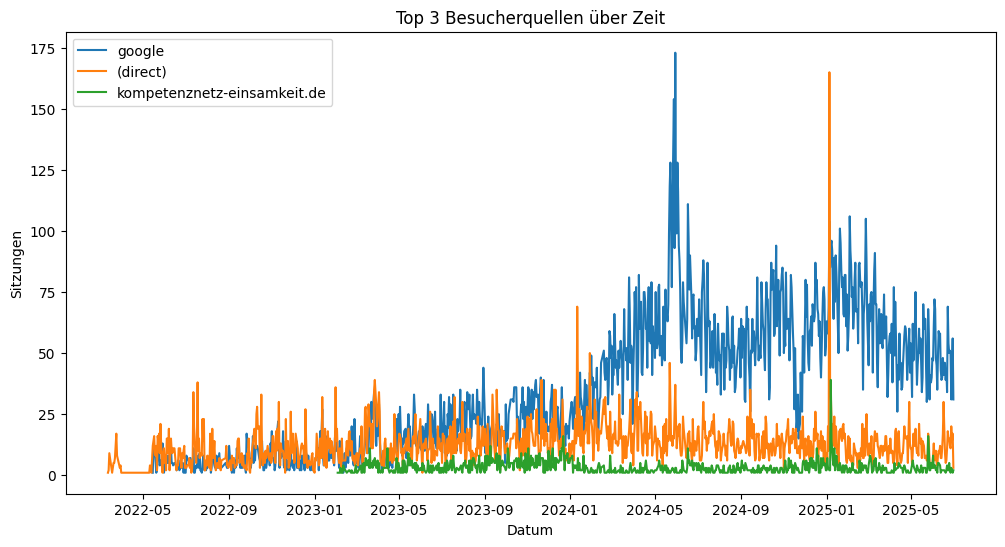

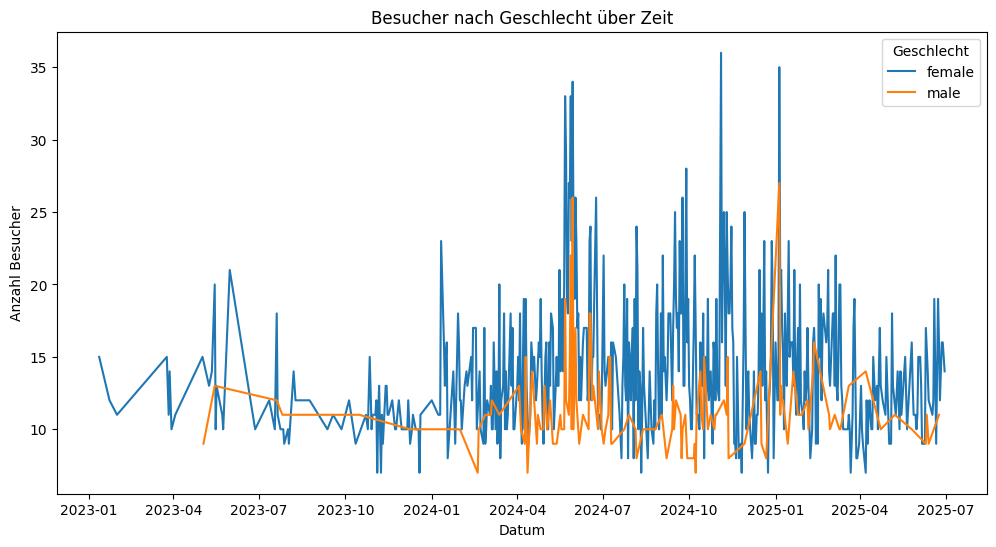

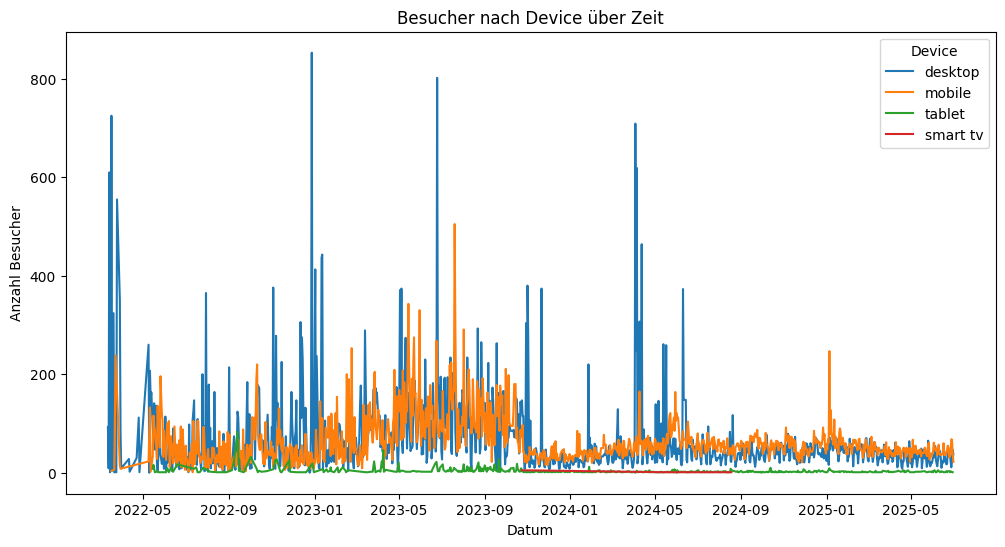

In [6]:
# Top 3 Besucherquellen über die Gesamtzeit
top_sources = (
    df_where_did_they_come_from.groupby("quelle")["sitzungen"]
    .sum()
    .sort_values(ascending=False)
    .head(3)
    .index
)

plt.figure(figsize=(12, 6))
for source in top_sources:
    subset = df_where_did_they_come_from[
        df_where_did_they_come_from["quelle"] == source
    ]
    subset_agg = subset.groupby("datum")["sitzungen"].sum().reset_index()
    sns.lineplot(data=subset_agg, x="datum", y="sitzungen", label=source)

plt.title("Top 3 Besucherquellen über Zeit")
plt.xlabel("Datum")
plt.ylabel("Sitzungen")
plt.legend()
plt.show()

# Geschlechter über Zeit plotten
df_gender = (
    df_who_was_visiting.groupby(["datum", "kategorie"])["wert"].sum().reset_index()
)

# Plot mit seaborn, x=datum, y=anzahl, hue=gender (für verschiedene Linien)
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_gender, x="datum", y="wert", hue="kategorie")

plt.title("Besucher nach Geschlecht über Zeit")
plt.xlabel("Datum")
plt.ylabel("Anzahl Besucher")
plt.legend(title="Geschlecht")
plt.show()


# Devices über Zeit plotten
df_devices = (
    df_what_devices_used.groupby(["datum", "kategorie"])["wert"].sum().reset_index()
)

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_devices, x="datum", y="wert", hue="kategorie")

plt.title("Besucher nach Device über Zeit")
plt.xlabel("Datum")
plt.ylabel("Anzahl Besucher")
plt.legend(title="Device")
plt.show()

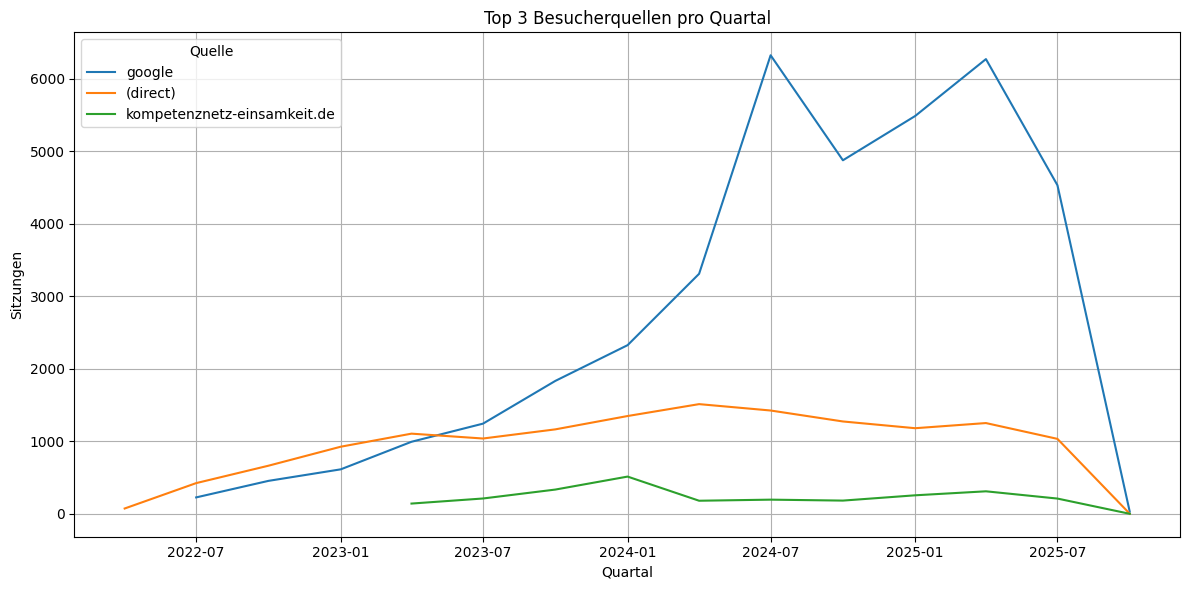

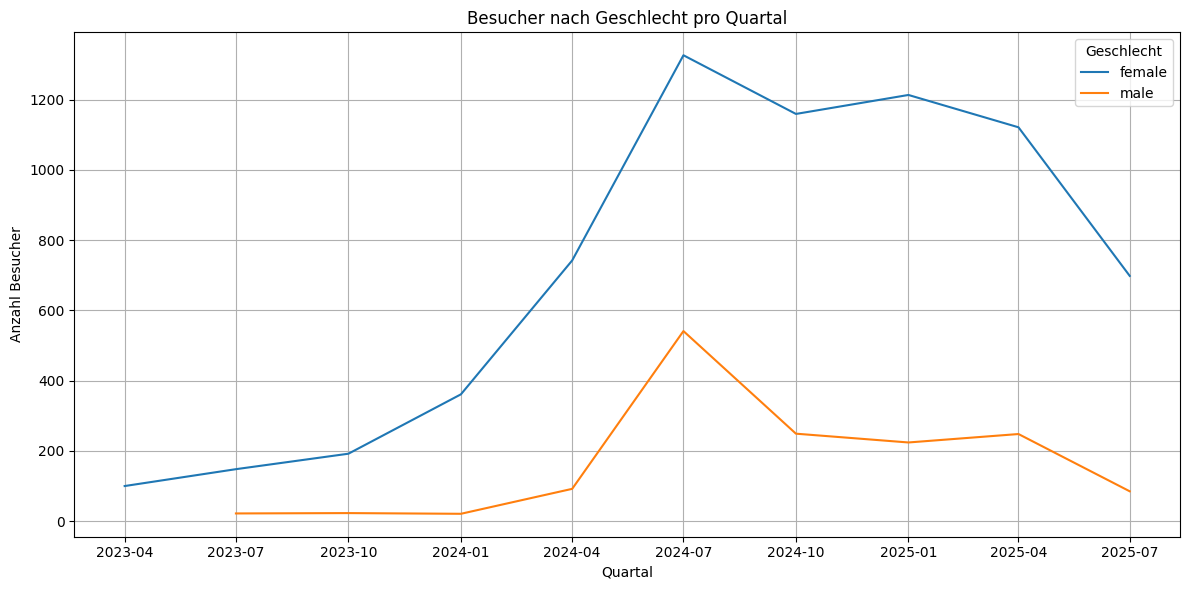

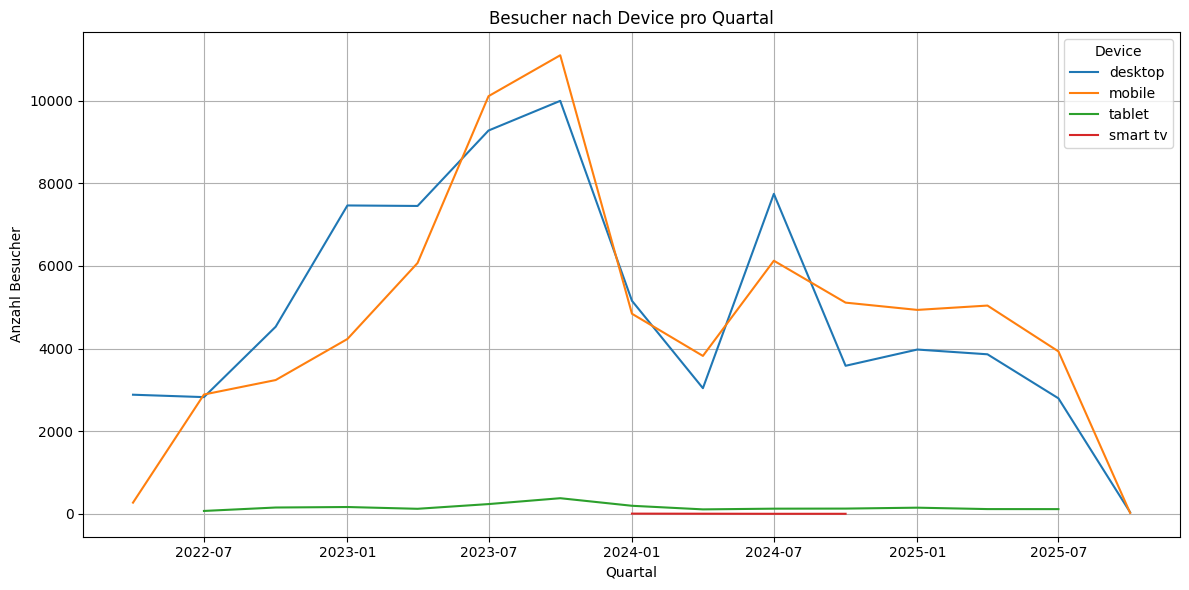

In [7]:
# --- Top 3 Besucherquellen pro Quartal ---
df_sources = df_where_did_they_come_from.copy()
df_sources["datum"] = pd.to_datetime(df_sources["datum"])
df_sources["quartal"] = df_sources["datum"].dt.to_period("Q")

top_sources = (
    df_sources.groupby("quelle")["sitzungen"]
    .sum()
    .sort_values(ascending=False)
    .head(3)
    .index
)

plt.figure(figsize=(12, 6))
for source in top_sources:
    subset = df_sources[df_sources["quelle"] == source]
    subset_agg = subset.groupby("quartal")["sitzungen"].sum().reset_index()
    subset_agg["quartal"] = subset_agg["quartal"].dt.to_timestamp(how="e")
    sns.lineplot(data=subset_agg, x="quartal", y="sitzungen", label=source)

plt.title("Top 3 Besucherquellen pro Quartal")
plt.xlabel("Quartal")
plt.ylabel("Sitzungen")
plt.legend(title="Quelle")
plt.grid(True)
plt.tight_layout()
plt.show()


# --- Geschlechter pro Quartal ---
df_gender = df_who_was_visiting.copy()
df_gender["datum"] = pd.to_datetime(df_gender["datum"])
df_gender["quartal"] = df_gender["datum"].dt.to_period("Q")

df_quartal_gender = (
    df_gender.groupby(["quartal", "kategorie"])["wert"].sum().reset_index()
)
df_quartal_gender["quartal"] = df_quartal_gender["quartal"].dt.to_timestamp(how="e")

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_quartal_gender, x="quartal", y="wert", hue="kategorie")

plt.title("Besucher nach Geschlecht pro Quartal")
plt.xlabel("Quartal")
plt.ylabel("Anzahl Besucher")
plt.legend(title="Geschlecht")
plt.grid(True)
plt.tight_layout()
plt.show()


# --- Devices pro Quartal ---
df_devices = df_what_devices_used.copy()
df_devices["datum"] = pd.to_datetime(df_devices["datum"])
df_devices["quartal"] = df_devices["datum"].dt.to_period("Q")

df_quartal_devices = (
    df_devices.groupby(["quartal", "kategorie"])["wert"].sum().reset_index()
)
df_quartal_devices["quartal"] = df_quartal_devices["quartal"].dt.to_timestamp(how="e")

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_quartal_devices, x="quartal", y="wert", hue="kategorie")

plt.title("Besucher nach Device pro Quartal")
plt.xlabel("Quartal")
plt.ylabel("Anzahl Besucher")
plt.legend(title="Device")
plt.grid(True)
plt.tight_layout()
plt.show()

<h2>📊 Cluster-Analyse der Landingpages: Nutzungsintensität verstehen</h2> <p>Um die Nutzung der Landingpages besser einordnen zu können, haben wir die Seiten nach ihrer <strong>Aufrufhäufigkeit</strong> mit einem Clustering-Verfahren in Gruppen unterteilt. Dabei kam das Verfahren <code>KMeans</code> mit <strong>vier Clustern</strong> zum Einsatz.</p> <p>Da sich zwei dieser Cluster in der Mitte lagen und ähnliche durchschnittliche Aufrufzahlen hatten, haben wir sie in der Darstellung zu einem gemeinsamen Label zusammengefasst. So ergibt sich eine anschauliche und verständliche Kategorisierung mit nur drei Gruppen:</p> <ul> <li><strong>Wenig aufgerufen</strong></li> <li><strong>Durchschnittlich aufgerufen</strong></li> <li><strong>Häufig aufgerufen</strong></li> </ul> <hr> <h3>🏷️ Wie wurden die Labels vergeben?</h3> <p>Die Cluster-Labels basieren auf dem <strong>Durchschnitt der Aufrufe innerhalb jedes Clusters</strong>. Wir haben die Cluster nach diesen Mittelwerten sortiert und inhaltlich benannt – vom niedrigsten zum höchsten Nutzungsniveau. Auch wenn intern vier Cluster berechnet wurden, erfolgt die Anzeige nur mit drei verständlichen Gruppenbezeichnungen.</p> <hr> <h3>🔝 Top 15 Landingpages und ihre Nutzung</h3> <p>Für die Analyse wurden die 15 am häufigsten aufgerufenen Seiten betrachtet. Diese verteilen sich wie folgt auf die Nutzungsintensitäts-Labels:</p> <ul> <li>▶️ <strong>2 Seiten</strong> sind <strong>häufig aufgerufen</strong></li> <li>▶️ <strong>4 Seiten</strong> sind <strong>durchschnittlich aufgerufen</strong></li> <li>▶️ <strong>9 Seiten</strong> sind <strong>wenig aufgerufen</strong></li> </ul> <p>Dies zeigt: Selbst unter den meistbesuchten Seiten gibt es viele, die im Verhältnis zu den Top-Spitzenreitern deutlich seltener aufgerufen wurden.</p> <hr> <h3>📈 Warum ist das nützlich?</h3> <ul> <li>Die <strong>Cluster helfen dabei, Landingpages nach Nutzungsintensität zu gruppieren</strong>, ohne dass man starre Schwellenwerte definieren muss.</li> <li>So lassen sich z. B. Seiten mit <strong>Optimierungspotenzial</strong> oder solche mit <strong>besonders hoher Sichtbarkeit</strong> gezielt identifizieren.</li> <li>Die farbige Visualisierung im Plot gibt einen schnellen Überblick über die Nutzungsstruktur der wichtigsten Seiten.</li> </ul>

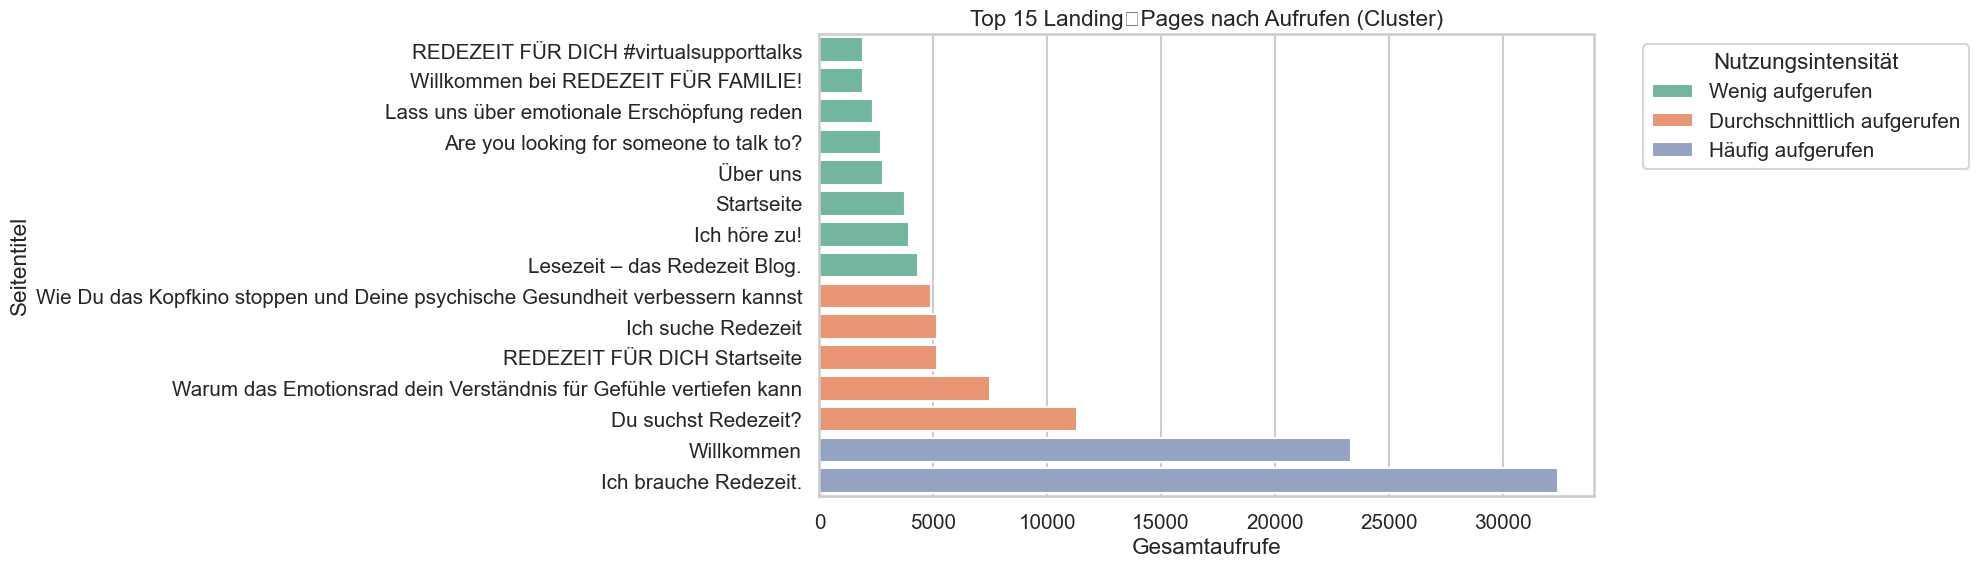

In [ ]:
# Top 15 Landingpages auswählen
df_lp = df_landingpage.groupby("seitentitel")["aufrufe"].sum().reset_index()
df_lp = df_lp.sort_values("aufrufe", ascending=False).head(15).copy()

# Seitentitel mit Regex kürzen: nur Teil vor dem "|"
df_lp["seitentitel"] = df_lp["seitentitel"].str.replace(r"\s*\|.*$", "", regex=True)

# Clustering vorbereiten
scaler = StandardScaler()
X_lp = scaler.fit_transform(df_lp[["aufrufe"]])
kmeans_lp = KMeans(n_clusters=4, random_state=42).fit(X_lp)
df_lp["cluster"] = kmeans_lp.labels_

# Mittelwerte je Cluster berechnen (für sinnvolle Labels)
cluster_means = df_lp.groupby("cluster")["aufrufe"].mean().sort_values()

# Mapping von Cluster‐Index zu verständlichem Label
cluster_labels = {
    cluster_means.index[0]: "Wenig aufgerufen",
    cluster_means.index[1]: "Durchschnittlich aufgerufen",
    cluster_means.index[2]: "Häufig aufgerufen",
    cluster_means.index[3]: "Häufig aufgerufen",
}

# Labels in DataFrame übernehmen
df_lp["cluster_label"] = df_lp["cluster"].map(cluster_labels)

# Nur die Top 15 Landingpages
top_lp = df_lp.sort_values("aufrufe", ascending=False).head(15)

# Plot mit beschrifteter Legende
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_lp.sort_values("aufrufe"),
    y="seitentitel",
    x="aufrufe",
    hue="cluster_label",
    palette="Set2",
)
plt.title("Top 15 Landing‑Pages nach Aufrufen (Cluster)")
plt.xlabel("Gesamtaufrufe")
plt.ylabel("Seitentitel")
plt.legend(title="Nutzungsintensität", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

<h2>📊 Analyse der Besucherquellen mit Clustering</h2>

<p>Wir haben die wichtigsten Kennzahlen für verschiedene Besucherquellen zusammengefasst:</p>
<ul>
  <li><strong>Sitzungen:</strong> Anzahl der Besuche</li>
  <li><strong>Aufrufe:</strong> Seitenaufrufe insgesamt</li>
  <li><strong>Aufrufe pro Sitzung:</strong> Durchschnittliche Seitenaufrufe je Besuch</li>
</ul>

<h3>🔎 Schritt 1 &amp; 2: Quellen gruppieren</h3>
<p>Die Top 4 Quellen werden einzeln betrachtet, alle anderen bündeln wir in "Andere". So behalten wir den Überblick, ohne dass seltene Quellen die Analyse verzerren.</p>

<h3>🔍 Schritt 3: Clustering</h3>
<p>Wir haben die Quellen basierend auf Sitzungen, Aufrufen und Aufrufen pro Sitzung in 3 Cluster eingeteilt, um typische Besucherquellen-Gruppen zu erkennen:</p>
<ul>
  <li><strong>Cluster 0:</strong> Kleiner Traffic, moderates Engagement</li>
  <li><strong>Cluster 1:</strong> Großer Traffic, geringes Engagement</li>
  <li><strong>Cluster 2:</strong> Mittlerer Traffic, hohes Engagement</li>
</ul>

<h3>📈 Interpretation der Cluster</h3>
<ul>
  <li><strong>Großer Traffic, geringes Engagement (Cluster 1):</strong> Quellen mit vielen Sitzungen, aber eher wenigen Seitenaufrufen pro Besuch (z.B. "google").</li>
  <li><strong>Mittlerer Traffic, hohes Engagement (Cluster 2):</strong> Quellen mit weniger Besuchen als Cluster 1, aber viel mehr Seitenaufrufen pro Sitzung (z.B. "direct").</li>
  <li><strong>Kleiner Traffic, moderates Engagement (Cluster 0):</strong> Quellen mit wenig Traffic und moderaten Seitenaufrufen pro Sitzung (z.B. "Andere", "kompetenznetz-einsamkeit.de").</li>
</ul>

<h3>💡 Fazit</h3>
<p>Diese Clustering-Analyse hilft, die Besucherquellen besser zu verstehen und gezielt Prioritäten zu setzen:</p>
<ul>
  <li><em>Große Traffic-Quellen</em> wie "google" brauchen Maßnahmen, um das Engagement zu erhöhen.</li>
  <li><em>Direktzugriffe</em> sind sehr engagiert, hier lohnt sich eine Pflege der Inhalte.</li>
  <li><em>Andere Quellen</em> sollten weiter beobachtet werden, da sie zwar kleiner sind, aber dennoch wertvolles Engagement liefern können.</li>
</ul>


'Cluster Zentren'

,sitzungen,aufrufe,aufrufe_pro_sitzung
0,4405.0,12111.666667,2.101716
1,38532.0,61745.000000,2.397830
2,14443.0,49042.000000,4.817538


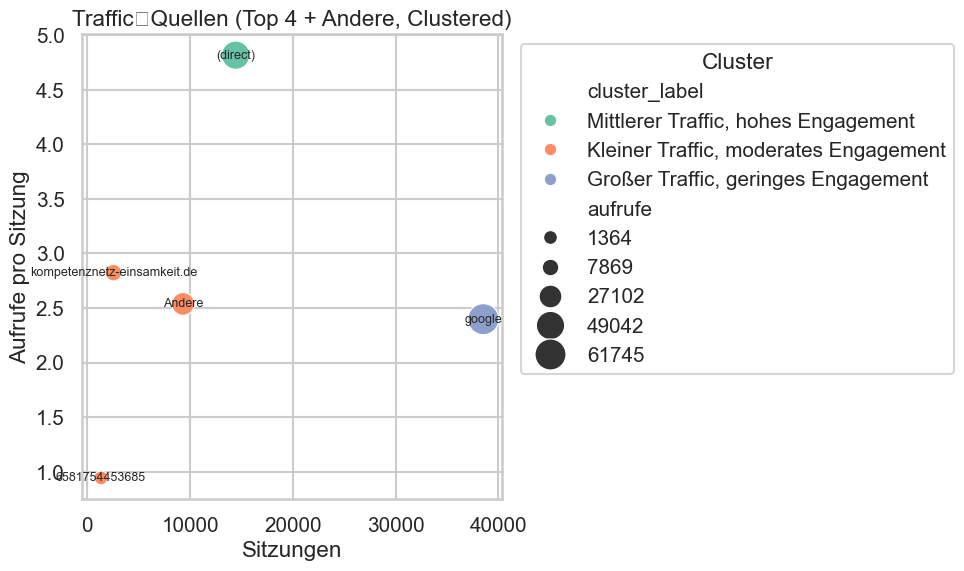

In [ ]:
# Metriken berechnen
df_ts = (
    df_where_did_they_come_from.groupby("quelle")
    .agg({"sitzungen": "sum", "aufrufe": "sum", "aufrufe_pro_sitzung": "mean"})
    .reset_index()
)

# Schritt 2: Nur Top 4 Quellen einzeln zeigen – Rest zu "Andere" zusammenfassen
top_n = 4
top_quellen = df_ts.sort_values("sitzungen", ascending=False).head(top_n)["quelle"]
df_ts["quelle_gruppe"] = df_ts["quelle"].where(
    df_ts["quelle"].isin(top_quellen), "Andere"
)

# Aggregation nach Quelle-Gruppe
df_ts_agg = (
    df_ts.groupby("quelle_gruppe")
    .agg({"sitzungen": "sum", "aufrufe": "sum", "aufrufe_pro_sitzung": "mean"})
    .reset_index()
)

# Schritt 3: Clustering
scaler = StandardScaler()
X = scaler.fit_transform(df_ts_agg[["sitzungen", "aufrufe", "aufrufe_pro_sitzung"]])
kmeans = KMeans(n_clusters=3, random_state=42)
df_ts_agg["cluster"] = kmeans.fit_predict(X)


# Schritt 4: Cluster-Labels definieren (basierend auf deiner Interpretation)
def cluster_label(cluster):
    if cluster == 0:
        return "Kleiner Traffic, moderates Engagement"
    elif cluster == 1:
        return "Großer Traffic, geringes Engagement"
    else:
        return "Mittlerer Traffic, hohes Engagement"


df_ts_agg["cluster_label"] = df_ts_agg["cluster"].apply(cluster_label)

# cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
# cluster_summary = pd.DataFrame(cluster_centers, columns=['sitzungen', 'aufrufe', 'aufrufe_pro_sitzung'])
# display("Cluster Zentren")
# display(cluster_summary)

# Schritt 5: Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_ts_agg,
    x="sitzungen",
    y="aufrufe_pro_sitzung",
    size="aufrufe",
    hue="cluster_label",
    sizes=(100, 500),
    palette="Set2",
    legend="full",
)
for _, row in df_ts_agg.iterrows():
    plt.text(
        row["sitzungen"],
        row["aufrufe_pro_sitzung"],
        row["quelle_gruppe"],
        fontsize=9,
        ha="center",
        va="center",
    )

plt.title("Traffic‑Quellen (Top 4 + Andere, Clustered)")
plt.xlabel("Sitzungen")
plt.ylabel("Aufrufe pro Sitzung")
plt.legend(title="Cluster", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

<h1>Erkennung und Visualisierung von ungewöhnlichen Tagen bei Seitenaufrufen</h1>

<p>Dieser Code zeigt uns, an welchen Tagen die Seitenaufrufe auf der Website besonders ungewöhnlich waren – also Ausreißer-Tage, die sich stark von normalen Tagen unterscheiden.</p>

<h2>Was macht der Code genau?</h2>

<ol>
  <li><strong>Datenpunkte darstellen:</strong> Jeder Punkt im Diagramm steht für die Seitenaufrufe an einem bestimmten Tag.</li>
  <li><strong>Farbliche Unterscheidung:</strong> Normale Tage sind grünlich dargestellt, ungewöhnliche (Ausreißer) Tage rot.</li>
  <li><strong>Datum hervorheben:</strong> Über jedem Ausreißer-Punkt steht das genaue Datum. So erkennt man sofort, an welchem Tag dieser Ausreißer aufgetreten ist.</li>
  <li><strong>Leichte Versetzung:</strong> Das Datum wird etwas oberhalb des Punktes angezeigt, damit es nicht überlappt und gut lesbar bleibt.</li>
</ol>

<h2>Was sieht man im Ergebnis?</h2>

<ul>
  <li>Viele blaue Punkte: Das sind ganz normale Tage mit üblichen Seitenaufrufen.</li>
  <li>Einige schwarze Punkte: Das sind die Ausreißer-Tage mit ungewöhnlich hohen oder niedrigen Seitenaufrufen.</li>
  <li>Zu jedem schwarzen Punkt sieht man das genaue Datum, so dass man schnell erkennt, wann die ungewöhnlichen Ereignisse stattgefunden haben.</li>
</ul>

<p>Diese Darstellung hilft dabei, besondere Tage mit auffälligen Besucherzahlen leicht zu erkennen und genau zuzuordnen.</p>


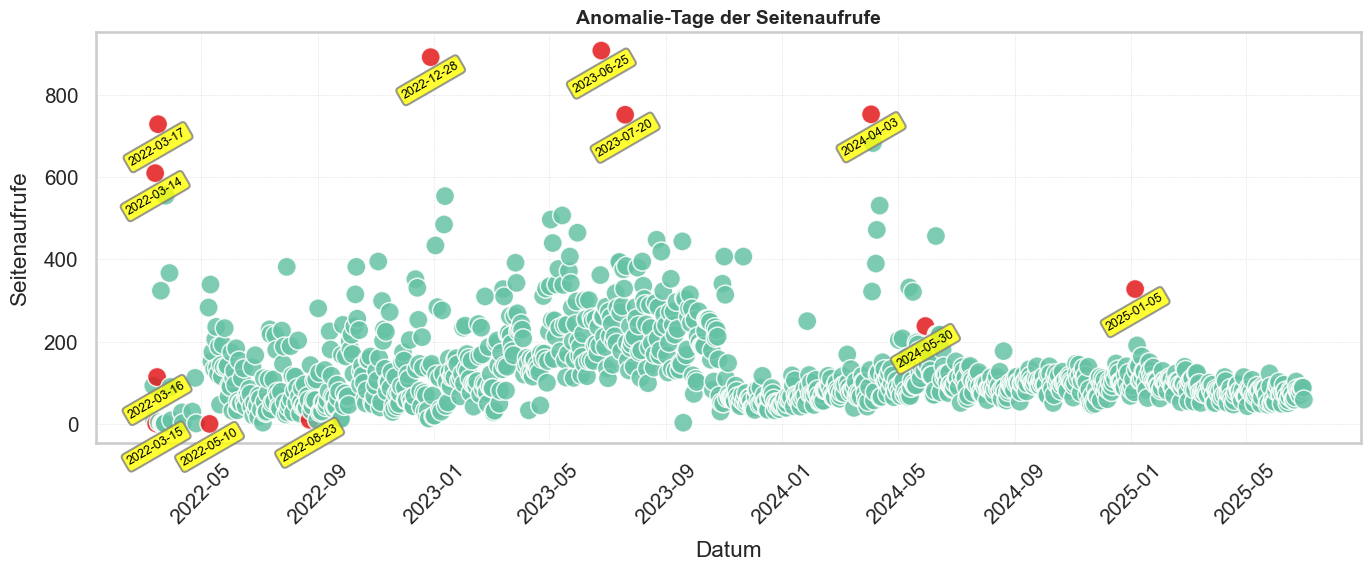

📋 **Anomalie-Tage und ihre auffälligen Kennzahlen:**

     datum  seitenaufrufe  nutzer_insgesamt absprungrate_in_prozent
2022-03-14            610                 3                    0.0%
2022-03-15              1                 2                  100.0%
2022-03-16            114                 2                  100.0%
2022-03-17            729                 2                  100.0%
2022-05-10              0                 1                  100.0%
2022-08-23             10                 6                  100.0%
2022-12-28            892                12                   10.5%
2023-06-25            908                29                    3.1%
2023-07-20            752               131                    4.8%
2024-04-03            753                88                   31.1%
2024-05-30            238               189                   28.8%
2025-01-05            328               272                   32.7%


In [ ]:
# Daten vorbereiten
daily = df_user_behaviors[
    ["datum", "seitenaufrufe", "nutzer_insgesamt", "absprungrate_in_prozent"]
].dropna()
daily["datum"] = pd.to_datetime(daily["datum"])
X_anom = daily[["seitenaufrufe", "nutzer_insgesamt", "absprungrate_in_prozent"]]

# Isolation Forest
iso = IsolationForest(contamination=0.01, random_state=42).fit(X_anom)
daily["anomaly"] = iso.predict(X_anom)

# Stil setzen
sns.set(style="whitegrid", context="talk", font_scale=0.9)
plt.figure(figsize=(14, 6))

# Plot zeichnen
palette = {1: "#66c2a5", -1: "#e31a1c"}  # türkis = normal, rot = Anomalie
sns.scatterplot(
    data=daily,
    x="datum",
    y="seitenaufrufe",
    hue="anomaly",
    palette=palette,
    legend=False,
    s=90,  # Punktgröße
    alpha=0.85,
)

# Labels unter Anomalie-Datenpunkten anzeigen
for _, row in daily[daily["anomaly"] == -1].iterrows():
    plt.text(
        row["datum"],
        row["seitenaufrufe"] - 100,  # x Einheiten unter dem Punkt
        row["datum"].strftime("%Y-%m-%d"),
        fontsize=9,
        color="black",
        ha="center",
        rotation=30,
        bbox=dict(
            facecolor="yellow", edgecolor="gray", boxstyle="round,pad=0.3", alpha=0.8
        ),
    )

# Achsen und Titel modernisieren
plt.title("Anomalie-Tage der Seitenaufrufe", fontsize=14, weight="bold")
plt.xlabel("Datum", labelpad=10)
plt.ylabel("Seitenaufrufe", labelpad=10)
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True, which="major", linestyle="--", linewidth=0.4, alpha=0.6)
plt.show()

# Tabelle mit Anomalie-Tagen
anomalies = daily[daily["anomaly"] == -1].copy()
anomalies = anomalies.sort_values("datum")

# Werte formatieren
anomalies["absprungrate_in_prozent"] = anomalies["absprungrate_in_prozent"].map(
    "{:.1f}%".format
)
anomalies["seitenaufrufe"] = anomalies["seitenaufrufe"].astype(int)
anomalies["nutzer_insgesamt"] = anomalies["nutzer_insgesamt"].astype(int)

# Ausgabe
display_columns = [
    "datum",
    "seitenaufrufe",
    "nutzer_insgesamt",
    "absprungrate_in_prozent",
]
print("📋 **Anomalie-Tage und ihre auffälligen Kennzahlen:**\n")
print(anomalies[display_columns].to_string(index=False))

<h1>Analyse der Zeitreihe: Trend, saisonale Muster und Rest bei Seitenaufrufen</h1>

<p>Mit diesem Code wird die Entwicklung der täglichen Seitenaufrufe über etwa ein Jahr untersucht. Dabei wird die Zeitreihe in mehrere Bestandteile zerlegt, um Muster besser zu verstehen:</p>

<h2>Was macht der Code genau?</h2>
<ul>
  <li><strong>Datenvorbereitung:</strong> Die täglichen Seitenaufrufe werden als Zeitreihe geordnet (Index ist das Datum). Fehlende Tage werden ergänzt, und fehlende Werte werden mit dem letzten bekannten Wert aufgefüllt.</li>
  <li><strong>Zerlegung (seasonal_decompose):</strong> Die Methode teilt die Daten in drei Teile auf:</li>
  <ul>
    <li><strong>Trend:</strong> Der langfristige Verlauf. Zeigt, ob die Seitenaufrufe im Mittel steigen, fallen oder stabil bleiben.</li>
    <li><strong>Saisonale Komponente:</strong> Wiederkehrende Schwankungen innerhalb eines Jahres (hier 365 Tage). Zum Beispiel höhere Aufrufe zu bestimmten Jahreszeiten oder Wochentagen.</li>
    <li><strong>Residual (Rest):</strong> Der Teil, der nicht durch Trend oder saisonale Muster erklärt wird – also zufällige Schwankungen oder Ausreißer.</li>
  </ul>
  <li><strong>Visualisierung:</strong> Die Grafik zeigt alle drei Teile als separate Linienplots, damit man sie gut vergleichen kann.</li>
</ul>

<h2>Was sieht man in der Grafik?</h2>
<ul>
  <li><strong>Originaldaten (obere Grafik):</strong> Die echten täglichen Seitenaufrufe.</li>
  <li><strong>Trend (zweite Grafik):</strong> Die geglättete Linie, die den allgemeinen Aufwärts- oder Abwärtstrend zeigt. Anfangs fehlen hier Werte, weil der Algorithmus erst genug Daten braucht, um den Trend zu berechnen.</li>
  <li><strong>Saisonale Komponente (dritte Grafik):</strong> Die regelmäßigen Schwankungen, die sich im Laufe eines Jahres wiederholen. Positive Werte zeigen Tage mit mehr Besuchern als der Trend erwartet, negative Werte Tage mit weniger Besuchern.</li>
  <li><strong>Residual / Rest (unterste Grafik):</strong> Die "Reste", also alles, was nicht durch Trend oder saisonale Muster erklärt wird. Hier sind die zufälligen Schwankungen und Ausreißer sichtbar.</li>
</ul>

<h2>Warum ist das wichtig?</h2>
<ul>
  <li><strong>Trend erkennen:</strong> Man sieht, ob die Webseite insgesamt mehr oder weniger besucht wird – eine wichtige Grundlage für Entscheidungen über Wachstum und Entwicklung.</li>
  <li><strong>Saisonale Muster verstehen:</strong> Man erkennt typische wiederkehrende Zeiten mit hoher oder niedriger Besucherzahl – etwa Feiertage, Wochenenden oder saisonale Einflüsse.</li>
  <li><strong>Rest analysieren:</strong> Hilft dabei, unerwartete Ereignisse (z.B. plötzliche Traffic-Spitzen) von normalen Mustern zu unterscheiden.</li>
  <li>Das alles hilft, die Webseite besser zu steuern, z.B. für Marketingaktionen, Serverplanung oder Nutzeranalysen.</li>
</ul>

<p>Zusammengefasst: Diese Zerlegung zeigt dir, wie sich deine Besucherzahlen über das Jahr verteilt entwickeln, welche regelmäßigen Muster es gibt und welche Schwankungen außergewöhnlich sind.</p>


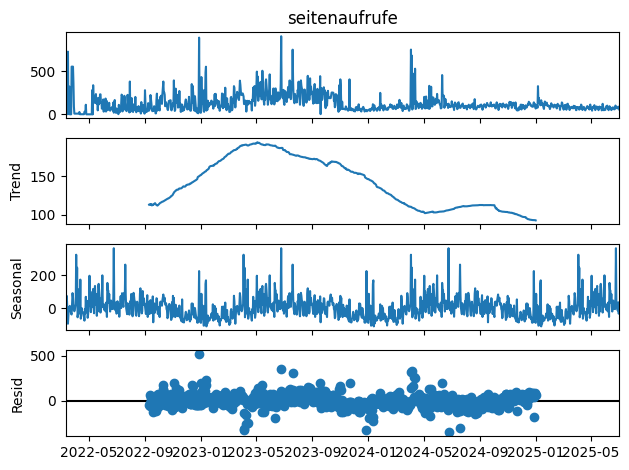

In [ ]:
# Analyse der Zeitreihe
ts = (
    df_user_behaviors.set_index("datum")["seitenaufrufe"]
    .asfreq("D")
    .fillna(method="ffill")
)
res = seasonal_decompose(ts, model="additive", period=365)
res.plot()
plt.tight_layout()
plt.show()
# display(res.trend.head())
# display(res.seasonal.head())

 <h2>Was zeigt dieser Plot? (PCA & K-Means für Nutzerverhalten)</h2>

  <p>
    In diesem Abschnitt wurde analysiert, wie sich Nutzer auf der Website verhalten – also zum Beispiel:
  </p>

  <ul>
    <li>Wie viele Seiten sie aufrufen</li>
    <li>Wie lange sie bleiben</li>
    <li>Wie oft sie abspringen</li>
    <li>Wie viele Seiten sie pro Sitzung anschauen</li>
  </ul>

  <h3>Was macht der Code eigentlich?</h3>

  <ol>
    <li><strong>Alle Nutzungsdaten werden zusammengeführt</strong> – z. B. Seitenaufrufe, Aufenthaltsdauer, Absprungrate usw.</li>
    <li><strong>Die Werte werden standardisiert</strong>, damit alle Merkmale vergleichbar sind (z. B. Prozentwerte und Sekunden).</li>
    <li>
      <strong>Dann kommt PCA (Hauptkomponentenanalyse):</strong>
      <ul>
        <li>Reduziert viele Merkmale auf 2 Hauptachsen</li>
        <li>Ermöglicht eine einfache 2D-Darstellung</li>
        <li>Erhält dabei möglichst viel Information</li>
      </ul>
    </li>
    <li>
      <strong>Jetzt folgt K-Means-Clustering:</strong>
      <ul>
        <li>Teilt die Nutzer automatisch in 3 Gruppen ein</li>
        <li>Basierend auf Ähnlichkeit ihres Verhaltens</li>
      </ul>
    </li>
  </ol>

  <h3>Was zeigt dieser Plot?</h3>
  <p>
    Der Scatterplot visualisiert das Verhalten der Nutzer als farbige Punkte in einem 2D-Raum. 
    Jeder Punkt steht für einen Tag (bzw. Nutzergruppe an einem Tag) und wurde nach seinem Verhalten einem Cluster zugeordnet.
  </p>
  <p>
    Die Farben zeigen die Gruppenzugehörigkeit – also, welche Nutzer sich ähnlich verhalten. Die Analyse basiert auf:
    Seitenaufrufen, Verweildauer, Absprungrate, Sitzungen und Nutzeranzahl.
  </p>

  <h3>Die drei erkannten Nutzer-Gruppen:</h3>
  <ul>
    <li><strong>Cluster 0 – Engagierte Nutzer 🧭</strong><br>
      Diese Nutzer schauen sich viele Seiten an (Ø 7,4 Seiten/Sitzung), bleiben lange (Ø 126 Sekunden) und springen selten ab (nur 9,6%).
    </li>
    <li><strong>Cluster 1 – Schnell-Weg-Nutzer 🏃‍♂️</strong><br>
      Diese Gruppe hat die meisten Nutzer, aber sie bleiben nur kurz (Ø 91 Sekunden), sehen sich wenige Seiten an (Ø 1,8) und springen oft sofort wieder ab (35% Absprungrate).
    </li>
    <li><strong>Cluster 2 – Tiefe Einzelbesucher 🔍</strong><br>
      Sehr wenige Nutzer, aber sie verbringen extrem viel Zeit auf der Seite (Ø 516 Sekunden) und schauen sich extrem viele Seiten an (Ø 274!). 
      Das könnte z. B. internes Personal oder Bots sein.
    </li>
  </ul>

  <h3>Wozu das Ganze?</h3>
  <p>
    Diese Art der Analyse hilft dir zu verstehen, welche Arten von Nutzer:innen es gibt, wie sie sich auf deiner Website bewegen,
    und ob es Gruppen gibt, die besonders interessant oder problematisch sind – z. B. viele Abspringer.
  </p>
  <p>
    Damit kannst du später gezielt Maßnahmen ergreifen: z. B. bestimmte Seiten optimieren, Inhalte besser anpassen oder besondere Nutzergruppen gezielt ansprechen.
  </p>


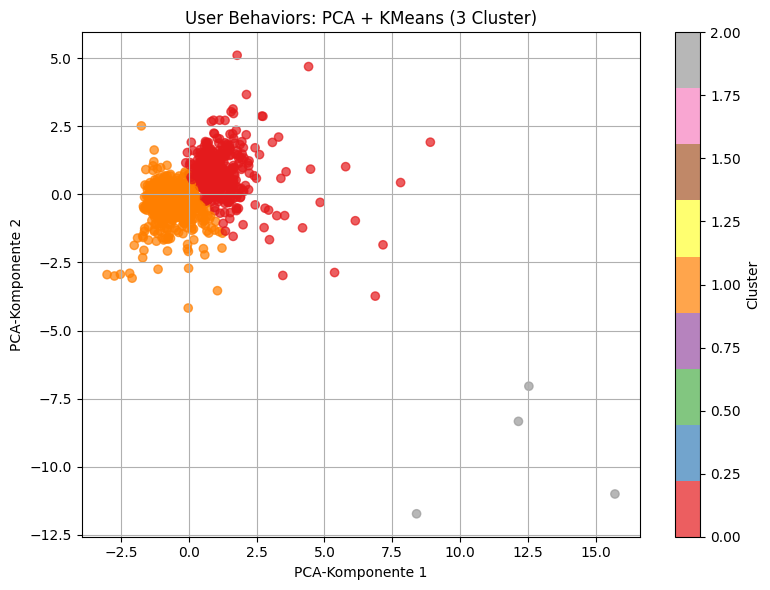

In [ ]:
features = [
    "seitenaufrufe",
    "nutzer_insgesamt",
    "zeit_in_sekunden",
    "absprungrate_in_prozent",
    "seiten_/_sitzung",
]
df_uv = df_user_behaviors[features].fillna(0)

X_uv = scaler.fit_transform(df_uv)
pca = PCA(n_components=2)
pcs = pca.fit_transform(X_uv)

kmeans_uv = KMeans(n_clusters=3, random_state=42).fit(pcs)
labels_uv = kmeans_uv.labels_

plt.figure(figsize=(8, 6))
scatter = plt.scatter(pcs[:, 0], pcs[:, 1], c=labels_uv, cmap="Set1", alpha=0.7)
plt.colorbar(scatter, label="Cluster")
plt.title("User Behaviors: PCA + KMeans (3 Cluster)")
plt.xlabel("PCA‑Komponente 1")
plt.ylabel("PCA‑Komponente 2")
plt.grid(True)
plt.tight_layout()
plt.show()